# Описание

Описание для ревью здесь. На гите вынесено в отдельный readme

# Проект: Система оценки риска ДТП для каршеринговой компании

## Описание проекта

Специалист по Data Science в каршеринговой компании получает задание на создание инновационной системы оценки риска ДТП по выбранному маршруту движения.

### Цель системы
- **Оценка риска**: Определение вероятности ДТП с любым повреждением ТС
- **Предупреждение**: Уведомление водителя при высоком уровне риска
- **Рекомендации**: Предложение альтернативных маршрутов

### Текущий статус
- **Стадия**: Предварительное обсуждение и проработка
- **Рынок**: Аналогичные решения отсутствуют
- **Задача**: Оценить возможность предсказания ДТП на основе исторических данных

## Критерии модели

| Критерий | Значение | Обоснование |
|----------|----------|-------------|
| **Целевая переменная** | `at_fault` из таблицы `parties` | Определение виновника ДТП |
| **Тип виновника** | Только автомобиль (`car`) | Фокус на автомобильные аварии |
| **Повреждения** | Все, кроме `SCRATCH` | Исключение незначительных повреждений |
| **Период данных** | 2012 год | Самые свежие доступные данные |
| **Обязательный фактор** | Возраст автомобиля | Требование заказчика |

## Структура базы данных

### Таблица `collisions` (Информация о ДТП)

| Поле | Тип | Описание | Значения |
|------|-----|----------|----------|
| `CASE_ID` | Уникальный ID | Идентификатор происшествия | - |
| `COLLISION_DATE` | Дата | Дата происшествия | ГГГГ/ММ/ДД |
| `COLLISION_TIME` | Время | Время происшествия | 24-часовой формат |
| `INTERSECTION` | Категория | Является ли перекрёстком | Y - Intersection<br>N - Not Intersection<br>-- - Not stated |
| `WEATHER_1` | Категория | Погодные условия | A - Clear (Ясно)<br>B - Cloudy (Облачно)<br>C - Raining (Дождь)<br>D - Snowing (Снегопад)<br>E - Fog (Туман)<br>F - Other (Другое)<br>G - Wind (Ветер)<br>- - Not Stated |
| `COLLISION_DAMAGE` | Категория | Серьёзность повреждений | 0 - SCRATCH (Царапина)<br>1 - FATAL ТС (Не подлежит восстановлению)<br>2 - SEVERE DAMAGE (Серьёзный ремонт)<br>3 - MIDDLE DAMAGE (Средний ремонт)<br>4 - SMALL DAMAGE (Незначительный ремонт) |
| `PRIMARY_COLLISION_FACTOR` | Категория | Основная причина ДТП | A - Code Violation (Нарушение ПДД)<br>B - Other Improper Driving<br>C - Other Than Driver<br>D - Unknown<br>E - Fell Asleep (Заснул)<br>- - Not Stated |
| `ROAD_SURFACE` | Категория | Состояние дороги | A - Dry (Сухая)<br>B - Wet (Мокрая)<br>C - Snowy or Icy (Снег/Лёд)<br>D - Slippery (Скользкая)<br>- - Not Stated |
| `LIGHTING` | Категория | Освещение | A - Daylight (Дневной свет)<br>B - Dusk-Dawn (Сумерки)<br>C - Dark-Street Lights (Темно с фонарями)<br>D - Dark-No Street Lights (Темно без фонарей)<br>E - Dark-Street Lights Not Functioning<br>- - Not Stated |
| `COUNTY_CITY_LOCATION` | Число | Номер географического района | - |
| `COUNTY_LOCATION` | Категория | Название географического района | Список названий |
| `DIRECTION` | Категория | Направление движения | N - North<br>E - East<br>S - South<br>W - West<br>- - Not Stated |
| `DISTANCE` | Число | Расстояние от главной дороги (м) | - |
| `LOCATION_TYPE` | Категория | Тип дороги | H - Highway (Шоссе)<br>I - Intersection (Перекрёсток)<br>R - Ramp (Рампа)<br>- - Not Stated |
| `PARTY_COUNT` | Число | Количество участников | - |
| `PCF_VIOLATION_CATEGORY` | Категория | Категория нарушения | 00-24 (см. детали ниже)<br>- - Not Stated |
| `TYPE_OF_COLLISION` | Категория | Тип столкновения | A - Head-On (Лоб в лоб)<br>B - Sideswipe (Сторона)<br>C - Rear End (Задняя часть)<br>D - Broadside (Боковой удар)<br>E - Hit Object (Удар объекта)<br>F - Overturned (Опрокинутый)<br>G - Vehicle/Pedestrian<br>H - Other<br>- - Not Stated |
| `MOTOR_VEHICLE_INVOLVED_WITH` | Категория | Дополнительные участники | Other motor vehicle<br>Fixed object<br>Parked motor vehicle<br>Pedestrian<br>Bicycle<br>Non-collision<br>Other object<br>Motor vehicle on other roadway<br>Animal<br>Train |
| `ROAD_CONDITION_1` | Категория | Дорожное состояние | A - Holes, Deep Ruts (Ямы, колея)<br>B - Loose Material on Roadway<br>C - Obstruction on Roadway<br>D - Construction or Repair Zone<br>E - Reduced Roadway Width<br>F - Flooded (Затоплено)<br>G - Other<br>H - No Unusual Condition<br>- - Not Stated |

#### Детализация PCF_VIOLATION_CATEGORY:
**00-24** - Категории нарушений:
- **01** - Вождение в состоянии опьянения
- **02** - Препятствие движению
- **03** - Небезопасная скорость
- **04** - Опасное сближение
- **05** - Неправильная сторона дороги
- **06** - Неправильное движение
- **07** - Небезопасная смена полосы
- **08** - Неправильный поворот
- **09** - Автомобильное право проезда
- **10** - Пешеходное право проезда
- **11** - Нарушение пешеходами
- **12** - Дорожные сигналы и знаки
- **13** - Неправильная парковка
- **14** - Освещение
- **15** - Тормоза
- **16** - Другое оборудование
- **17** - Другие нарушения
- **18** - Кроме водителя/пешехода
- **19** - Превышение скорости
- **20** - Нарушение пешехода
- **21** - Опасный старт
- **22** - Другое неправильное вождение
- **23** - Пешеход в состоянии опьянения
- **24** - Заснул
- **00** - Unknown

### Таблица `parties` (Участники ДТП)

| Поле | Тип | Описание | Значения |
|------|-----|----------|----------|
| `CASE_ID` | ID | Связь с происшествием | Уникальный номер ДТП |
| `PARTY_NUMBER` | Число | Номер участника | 1-N (по количеству участников) |
| `PARTY_TYPE` | Категория | Тип участника | 1 - Car (Авто)<br>2 - Road bumper (Отбойник)<br>3 - Building (Строения)<br>4 - Road signs (Дорожные знаки)<br>5 - Other (Другое)<br>6 - Operator (Оператор)<br>- - Not Stated |
| `AT_FAULT` | Бинарный | **Целевая переменная** - Виновность участника | 0 - Не виновен<br>1 - Виновен |
| `INSURANCE_PREMIUM` | Число | Сумма страховки | Тысячи долларов $ |
| `PARTY_DRUG_PHYSICAL` | Категория | Физическое состояние участника | E - Under Drug Influence (Под воздействием лекарств)<br>F - Impairment - Physical (Ухудшение состояния)<br>G - Impairment Unknown (Не известно)<br>H - Not Applicable (Не оценивался)<br>I - Sleepy/Fatigued (Сонный/Усталый)<br>- - Not Stated |
| `PARTY_SOBRIETY` | Категория | Трезвость участника | A - Had Not Been Drinking (Не пил)<br>B - Had Been Drinking, Under Influence (Был пьян, под влиянием)<br>C - Had Been Drinking, Not Under Influence (Был пьян, не под влиянием)<br>D - Had Been Drinking, Impairment Unknown (Был пьян, ухудшение неизвестно)<br>G - Impairment Unknown (Неизвестно ухудшение)<br>H - Not Applicable (Не оценивался)<br>- - Not Stated |
| `CELLPHONE_IN_USE` | Бинарный | Использование телефона | 0 - Не использовался<br>1 - Использовался (в т.ч. громкая связь) |

### Таблица `vehicles` (Транспортные средства)

| Поле | Тип | Описание | Значения |
|------|-----|----------|----------|
| `ID` | Уникальный ID | Индекс записи в таблице | - |
| `CASE_ID` | ID | Связь с происшествием | Уникальный номер ДТП |
| `PARTY_NUMBER` | Число | Связь с участником | 1-N (соответствует PARTY_NUMBER в таблице parties) |
| `VEHICLE_TYPE` | Категория | Тип кузова | MINIVAN (Минивэн)<br>COUPE (Купе)<br>SEDAN (Седан)<br>HATCHBACK (Хэтчбек)<br>OTHER (Другой) |
| `VEHICLE_TRANSMISSION` | Категория | Тип коробки передач | auto - Автоматическая<br>manual - Ручная<br>- - Not Stated |
| `VEHICLE_AGE` | Число | **Возраст автомобиля** | Количество лет |

## Ключевые вопросы для исследования

1. **Возможность создания системы**
   - Можно ли адекватно оценивать водительский риск при выдаче авто?

2. **Дополнительные факторы**
   - Какие данные необходимо собирать для улучшения модели?

3. **Техническое оснащение**
   - Нужно ли оборудовать автомобиль датчиками или камерами?

## Ожидаемые результаты

- Модель предсказания ДТП с оценкой важности факторов
- Анализ ключевых факторов аварийности
- Рекомендации по разработке системы оценки риска
- Предложения по техническому оснащению автомобилей

---

*Проект направлен на создание инновационной системы безопасности для каршерингового сервиса*

# Импорты

In [1]:
%%time
# здесь будем ставить все, чего нам не хватает
# !pip install missingno -q
# !pip install optuna -q
# !pip install tqdm -q
# !pip install seaborn -q
# !pip install torch -q
# !pip install scikit-learn -q
# !pip install statsmodels -q
# !pip install catboost -q
# !pip install shap -q

CPU times: total: 0 ns
Wall time: 4.53 μs


In [2]:

# Базовые библиотеки
import sys
import time
import socket
import logging
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Работа с базами данных
import psycopg2
from sqlalchemy import create_engine
import sqlalchemy

# Машинное обучение — модели
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# Статистика и интерпретация
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap

# Sklearn: предобработка, обучение, метрики
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    FunctionTransformer,
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    KFold,
    cross_val_score,
)
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (
    roc_auc_score,
    make_scorer,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score
)
from sklearn.inspection import permutation_importance

# Оптимизация гиперпараметров
import optuna
from optuna.samplers import TPESampler
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Прочее
from tqdm import tqdm

# Импорт функций проекта
from func import (
    check_data,
    drop_duplicated,
    plot_combined,
    calc_target_correlations,
    plot_categorical_columns,
    plot_scatter_with_numerical,
    suggest_param,
    EarlyStoppingCallback,
)
from creds import db_config

# Настройка логирования
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(name)s: %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
logger = logging.getLogger(__name__)

# Отключение предупреждений
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=UserWarning)


e:\my_github\yandex_practicum_ds\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Константы

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
N_JOBS = 2
N_ITER = 10000 # число итераций для перебора и поиска лучших параметров
EARLY_STOP = 2

# Подключение к базе и получение данных

In [4]:
# Импортируем конфигурацию из отдельного файла
try:
    logger.info("Конфигурация загружена из creds.py")
except ImportError:
    logger.info("Файл creds.py не найден")
    db_config = {
        'user': input("Введите имя пользователя: "),
        'pwd': input("Введите пароль: "),
        'host': input("Введите хост: "),
        'port': input("Введите порт: "),
        'db': input("Введите название БД: ")
    }

2025-11-28 10:04:34 [INFO] __main__: Конфигурация загружена из creds.py


In [5]:
def check_host_availability():
    """Проверка доступности хоста"""
    try:
        socket.create_connection((db_config['host'], db_config['port']), timeout=10)
        logger.info("Хост доступен, можем подключаться и выгружать данные")
        return True
    except socket.error as e:
        logger.info(f"Хост недоступен: {e}")
        sys.exit("ОСТАНОВКА: Не удалось подключиться к базе данных. Дальнейшее выполнение невозможно.")

check_host_availability()

2025-11-28 10:04:34 [INFO] __main__: Хост доступен, можем подключаться и выгружать данные


True

In [6]:
# если с хостом все ок, то подключаемся и забираем данные
connection_string = f"postgresql://{db_config['user']}:{db_config['pwd']}@{db_config['host']}:{db_config['port']}/{db_config['db']}"
engine = create_engine(connection_string)

def load_data_safe(engine, table_name_or_query, use_chunks=True, chunksize=300000):
    """Загружает данные - либо таблицу целиком, либо по SQL-запросу"""
    try:
        if isinstance(table_name_or_query, str) and table_name_or_query.strip().upper().startswith('SELECT'):
            logger.info(f"Загружаем данные по SQL-запросу...")
            result = pd.read_sql(table_name_or_query, engine)
            logger.info(f"Загружено: {result.shape[0]} строк, {result.shape[1]} столбцов")
            return result
        else:
            table_name = table_name_or_query
            if use_chunks:
                logger.info(f"Загружаем таблицу {table_name} по частям...")
                count_query = f"SELECT COUNT(*) FROM {table_name}"
                total_rows = pd.read_sql(count_query, engine).iloc[0,0]
                logger.info(f"Всего строк в {table_name}: {total_rows}")
                
                chunks = []
                for offset in range(0, total_rows, chunksize):
                    query = f"SELECT * FROM {table_name} LIMIT {chunksize} OFFSET {offset}"
                    chunk = pd.read_sql(query, engine)
                    chunks.append(chunk)
                    logger.info(f"Загружено {len(chunk)} строк (прогресс: {min(offset + chunksize, total_rows)}/{total_rows})")
                
                result = pd.concat(chunks, ignore_index=True)
                logger.info(f"{table_name}: {result.shape[0]} строк, {result.shape[1]} столбцов")
                return result
            else:
                logger.info(f"Загружаем таблицу {table_name}...")
                result = pd.read_sql(f"SELECT * FROM {table_name}", engine)
                logger.info(f"{table_name}: {result.shape[0]} строк, {result.shape[1]} столбцов")
                return result
        
    except Exception as e:
        logger.error(f"Ошибка при загрузке: {e}")
        return None

def load_all_tables_safe(engine, tables_config):
    """Безопасная загрузка всех таблиц/запросов"""
    dataframes = {}
    
    for table_name, table_ref in tables_config.items():
        dataframes[table_name] = load_data_safe(engine, table_ref)
    
    return dataframes

In [7]:
logger.info("=== ЗАГРУЗКА ПОЛНЫХ ТАБЛИЦ ===")
full_tables_config = {
    'collisions': 'collisions',
    'parties': 'parties', 
    'vehicles': 'vehicles'
}

df_dict_full = load_all_tables_safe(engine, full_tables_config)

# проверяем что все таблицы загружены
successful_tables = {k: v for k, v in df_dict_full.items() if v is not None}

if len(successful_tables) == len(full_tables_config):
    collisions_default = df_dict_full['collisions']
    parties_default = df_dict_full['parties']
    vehicles_default = df_dict_full['vehicles']
    logger.info("Все полные данные успешно загружены")
else:
    logger.warning(f"Загружены только таблицы: {list(successful_tables.keys())}")

2025-11-28 10:04:34 [INFO] __main__: === ЗАГРУЗКА ПОЛНЫХ ТАБЛИЦ ===
2025-11-28 10:04:34 [INFO] __main__: Загружаем таблицу collisions по частям...
2025-11-28 10:04:34 [INFO] __main__: Всего строк в collisions: 1400000
2025-11-28 10:04:43 [INFO] __main__: Загружено 300000 строк (прогресс: 300000/1400000)
2025-11-28 10:04:50 [INFO] __main__: Загружено 300000 строк (прогресс: 600000/1400000)
2025-11-28 10:04:58 [INFO] __main__: Загружено 300000 строк (прогресс: 900000/1400000)
2025-11-28 10:05:06 [INFO] __main__: Загружено 300000 строк (прогресс: 1200000/1400000)
2025-11-28 10:05:11 [INFO] __main__: Загружено 200000 строк (прогресс: 1400000/1400000)
2025-11-28 10:05:11 [INFO] __main__: collisions: 1400000 строк, 20 столбцов
2025-11-28 10:05:12 [INFO] __main__: Загружаем таблицу parties по частям...
2025-11-28 10:05:12 [INFO] __main__: Всего строк в parties: 2752408
2025-11-28 10:05:15 [INFO] __main__: Загружено 300000 строк (прогресс: 300000/2752408)
2025-11-28 10:05:18 [INFO] __main__: З

In [8]:
collisions_default.head()

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0.0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1.0,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


In [9]:
parties_default.head()

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0


In [10]:
vehicles_default.head()

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3.0
1,1,3858022,1,sedan,auto,3.0
2,1175712,5305030,1,sedan,auto,3.0
3,1175717,5305033,3,sedan,auto,5.0
4,1175722,5305034,2,sedan,auto,5.0


Да, много данных. Посмотрим, как это число изменится если мы сразу получим только то, что нам нужно

В тз у нас есть ограничения на выборку - учтем их сразу в запросах, чтобы не тащить все данные.  
- Для модели выбрать тип виновника — только машина (car).  
- Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).  
- Для моделирования ограничиться данными за 2012 год — они самые свежие. Т.е. берем все что до 2013 года.  

Также отберем только нужные признаки, который будут полезны для модели.

# Отбор признаков для модели предсказания виновности в ДТП

## Признаки для модели

Из таблицы `collisions`

| Признак | Описание |
|---------|-------------|
| `WEATHER_1` | Погодные условия напрямую влияют на видимость и управляемость транспортным средством |
| `ROAD_SURFACE` | Состояние дорожного покрытия значительно воздействует на риск возникновения ДТП |
| `LIGHTING` | Уровень освещённости влияет на видимость и скорость реакции водителя |
| `INTERSECTION` | Перекрестки являются зонами повышенной аварийности и сложности манёвров |
| `LOCATION_TYPE` | Тип дороги определяет характер движения и потенциальные риски |
| `COUNTY_CITY_LOCATION` | Без детальных карт и анализа дорожной инфраструктуры сложно интерпретировать |
| `COUNTY_LOCATION` | Географическая привязка без контекста дорожных условий |
| `ROAD_CONDITION_1` | Дополнительные дорожные условия создают дополнительные факторы риска |
| `DIRECTION` | Направление движения само по себе не является информативным признаком, но пусть будет |
| `CONTROL_DEVICE` | В описании данных признака нет, но судя по всему речь о светофорах и другим устройствам контроля движения |

Из таблицы `parties`

| Признак | Описание |
|---------|-------------|
| `CELLPHONE_IN_USE` | Использование телефона за рулём приводит к отвлечению внимания и нарушениям |
 `INSURANCE_PREMIUM` | Тут тонкий момент, если это именно страхова премия, а не возмещение, то ок, можно использовать в работе |

Из таблицы `vehicles`

| Признак | Описание |
|---------|-------------|
| `VEHICLE_AGE` | Обязателен по ТЗ - возраст автомобиля может влиять на техническую исправность и безопасность |
| `VEHICLE_TYPE` | Тип кузова может влиять на управляемость и поведение транспортного средства |

---

## Таблица признаков для исключения

| Категория | Признак | Причина исключения |
|-----------|---------|-------------------|
| **Признаки-утечки** | `PARTY_SOBRIETY` | Состояние трезвости является ключевым фактором определения виновника |
| | `PCF_VIOLATION_CATEGORY` | Категории нарушений ПДД напрямую коррелируют с виновностью |
| | `TYPE_OF_COLLISION` | Тип столкновения может указывать на действия виновника аварии |
| | `PARTY_DRUG_PHYSICAL` | Физическое состояние водителя напрямую влияет на виновность |
| | `PARTY_NUMBER` | Технический номер участника в рамках ДТП |
| | `PARTY_COUNT` | Количество участников ДТП слабо коррелирует с виновностью конкретного водителя |
| | `MOTOR_VEHICLE_INVOLVED_WITH` | Тип второго участника менее важен, чем действия самого виновника |
| | `DISTANCE` | Расстояние от главной дороги без дополнительного контекста не информативно |
| **Технические идентификаторы** | `CASE_ID` | Уникальный идентификатор, не несет прогнозной способности |
| | `ID` | Уникальный идентификатор случая |
| **Временные признаки** | `COLLISION_DATE` | Рекомендуется вынести в отдельный анализ сезонности |
| | `COLLISION_TIME` | Будет преобразован в циклические признаки (час, день недели) |
| **Избыточные признаки** | `PRIMARY_COLLISION_FACTOR` | Дублирует информацию из `PCF_VIOLATION_CATEGORY` |


## Рекомендации по преобразованию признаков

### Временные признаки для преобразования:
- **`COLLISION_DATE`** → месяц, день недели, сезон
- **`COLLISION_TIME`** → час (с циклическим кодированием)

### Признаки для дальнейшего анализа:
- Географические признаки могут быть полезны при наличии дополнительных данных о дорожной инфраструктуре
- Временные признаки после преобразования станут ценным источником информации о сезонности и временных паттернах ДТП

Ретроспектива небольшая:  
1) после мая 2012 у нас данных почти нет, значит для нормальной оценки сезонности надо брать все ДО 2012 года, иначе получим некорректные данные при расчетах  
2) party_drug_physical и location_type - практически пустые признаки, вообще не берем их, чтобы не мешали и не фонили

In [11]:
logger.info("=== ЗАГРУЗКА ОТФИЛЬТРОВАННЫХ ТАБЛИЦ ===")

# оптимизированные запросы с учетом отбора признаков
query = """
SELECT 
    -- Из collisions
    -- c.case_id,
    c.weather_1,
    c.road_surface,
    c.lighting,
    c.intersection,
    c.location_type,
    c.pcf_violation_category,
    c.type_of_collision,
    c.road_condition_1,
    c.direction,
    -- c.distance,
    c.collision_date::date,
    c.collision_time::time,
    c.county_city_location,
    c.county_location,
    c.control_device,
    
    -- Из parties
    p.party_number,
    p.at_fault,
    p.party_sobriety,
    p.cellphone_in_use,
    p.insurance_premium,
    
    -- Из vehicles
    v.vehicle_type,
    v.vehicle_age,
    v.vehicle_transmission
    
FROM collisions c
JOIN parties p ON c.case_id = p.case_id
JOIN vehicles v ON c.case_id = v.case_id AND p.party_number = v.party_number
WHERE c.collision_date < '2012-12-31'
-- WHERE c.collision_date < '2012-01-01'
    AND  c.collision_date > '2008-12-31'
    AND c.collision_damage <> 'scratch'
    AND p.party_type = 'car'
    AND v.vehicle_age < 11
"""

filtered_tables_config = {
    'df': query
}

2025-11-28 10:05:48 [INFO] __main__: === ЗАГРУЗКА ОТФИЛЬТРОВАННЫХ ТАБЛИЦ ===


In [12]:
df_dict_filtered = load_all_tables_safe(engine, filtered_tables_config)
successful_tables = {k: v for k, v in df_dict_filtered.items() if v is not None}

if len(successful_tables) == len(filtered_tables_config):
    df = df_dict_filtered['df']
    
    logger.info("Все отфильтрованные данные успешно загружены и готовы к анализу.")
    
else:
    logger.warning(f"Загружены не все таблицы. Успешно: {list(successful_tables.keys())}")
    
    if 'df' in successful_tables:
        df = df_dict_filtered['df']

2025-11-28 10:05:48 [INFO] __main__: Загружаем данные по SQL-запросу...
2025-11-28 10:06:01 [INFO] __main__: Загружено: 460623 строк, 22 столбцов
2025-11-28 10:06:01 [INFO] __main__: Все отфильтрованные данные успешно загружены и готовы к анализу.


# EDA

### общие данные

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460623 entries, 0 to 460622
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   weather_1               458750 non-null  object 
 1   road_surface            457269 non-null  object 
 2   lighting                458484 non-null  object 
 3   intersection            458622 non-null  float64
 4   location_type           212101 non-null  object 
 5   pcf_violation_category  455059 non-null  object 
 6   type_of_collision       457986 non-null  object 
 7   road_condition_1        457555 non-null  object 
 8   direction               353531 non-null  object 
 9   collision_date          460623 non-null  object 
 10  collision_time          459992 non-null  object 
 11  county_city_location    460623 non-null  object 
 12  county_location         460623 non-null  object 
 13  control_device          458820 non-null  object 
 14  party_number        

None

,weather_1,road_surface,lighting,intersection,location_type,pcf_violation_category,type_of_collision,road_condition_1,direction,collision_date,...,county_location,control_device,party_number,at_fault,party_sobriety,cellphone_in_use,insurance_premium,vehicle_type,vehicle_age,vehicle_transmission
233013,clear,dry,daylight,0.0,None,unknown,sideswipe,normal,south,2011-07-18,...,san bernardino,functioning,2,0,had not been drinking,0.0,44.0,sedan,3,manual
206480,clear,dry,daylight,0.0,None,speeding,rear end,normal,south,2011-10-13,...,los angeles,none,3,0,had not been drinking,0.0,40.0,sedan,5,auto
107818,clear,dry,daylight,1.0,None,None,broadside,normal,None,2012-04-06,...,los angeles,none,2,0,had not been drinking,0.0,47.0,sedan,10,auto
422920,clear,dry,daylight,0.0,highway,dui,rear end,normal,south,2011-10-11,...,orange,none,1,0,had not been drinking,0.0,35.0,sedan,5,auto
89028,clear,dry,daylight,0.0,highway,improper turning,overturned,normal,north,2009-10-22,...,san bernardino,none,1,1,had not been drinking,0.0,21.0,coupe,3,manual


weather_1                   1873
road_surface                3354
lighting                    2139
intersection                2001
location_type             248522
pcf_violation_category      5564
type_of_collision           2637
road_condition_1            3068
direction                 107092
collision_time               631
control_device              1803
party_sobriety              6894
cellphone_in_use           40908
insurance_premium           4007
vehicle_transmission        4829
dtype: int64

None

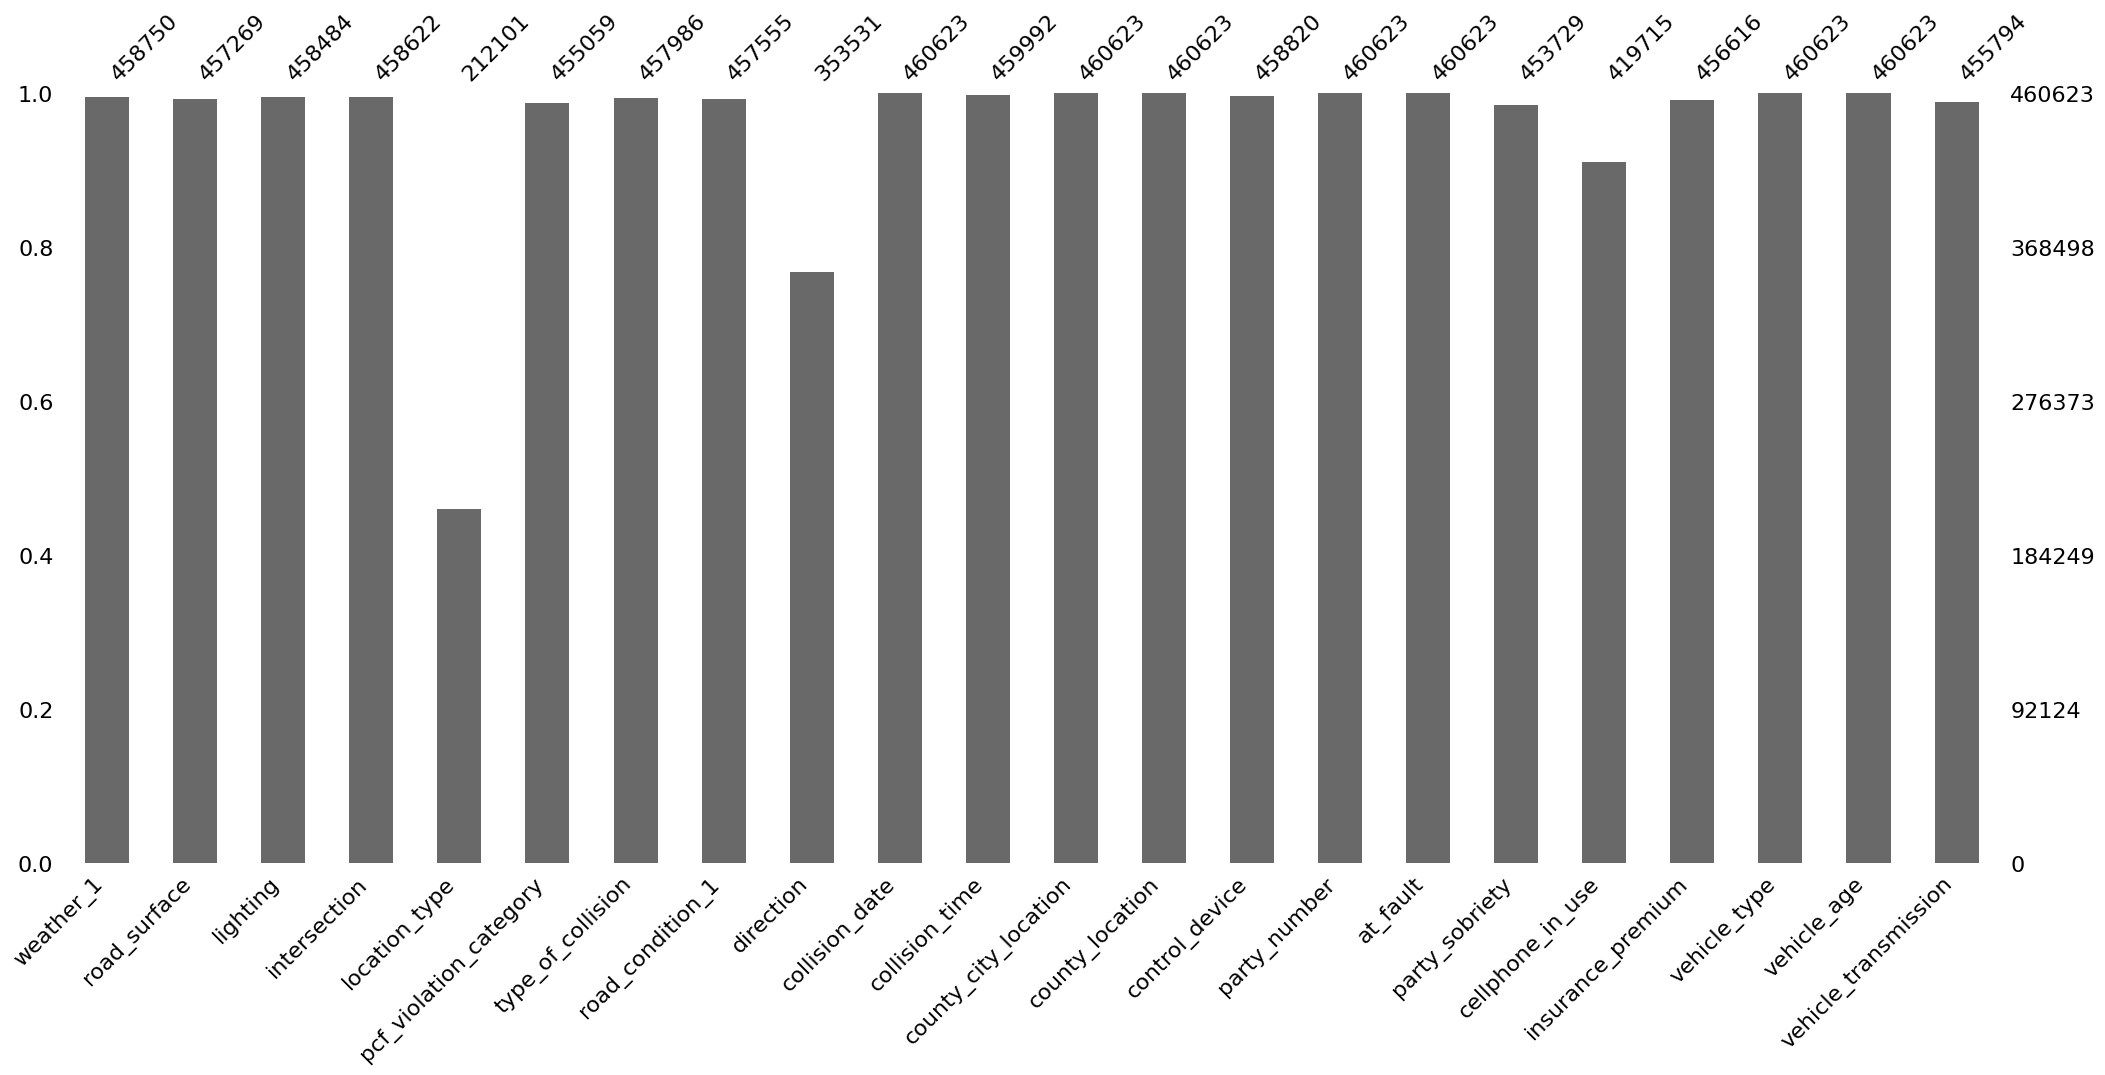

,count,mean,std,min,25%,50%,75%,max
intersection,458622.0,0.222320,0.415806,0.0,0.0,0.0,0.0,1.0
party_number,460623.0,1.526546,0.663029,1.0,1.0,1.0,2.0,13.0
at_fault,460623.0,0.499719,0.500000,0.0,0.0,0.0,1.0,1.0
cellphone_in_use,419715.0,0.019211,0.137265,0.0,0.0,0.0,0.0,1.0
insurance_premium,456616.0,35.416470,14.241635,0.0,23.0,33.0,46.0,105.0
vehicle_age,460623.0,4.356843,2.592554,0.0,3.0,4.0,6.0,10.0


In [13]:
df = check_data(df)

Пу-пу-пу....  
1) Первое что бросается в глаза - много пропусков, но сделать мы с ними ничего не можем, поэтому заполним их как unknown  
2) У нас в основном все признаки категориальные, ок, оценим их распределение на таргет  
3) Сгруппируем по месяцам, чтобы понять сезонность ДТП  

### детальные данные

Детальнее изучим каждый признак

In [14]:
logger.info("Все столбцы таблицы:")
logger.info(", ".join(df.columns))
logger.info("="*50)

exclude_columns = ['case_id', 'collision_date', 'collision_time', 'distance']  # для исключения

for col in df.columns:
    if col not in exclude_columns:
        display(f"{col}: ", end="")
        display(df[col].unique())

2025-11-28 10:06:08 [INFO] __main__: Все столбцы таблицы:
2025-11-28 10:06:08 [INFO] __main__: weather_1, road_surface, lighting, intersection, location_type, pcf_violation_category, type_of_collision, road_condition_1, direction, collision_date, collision_time, county_city_location, county_location, control_device, party_number, at_fault, party_sobriety, cellphone_in_use, insurance_premium, vehicle_type, vehicle_age, vehicle_transmission
2025-11-28 10:06:08 [INFO] __main__: ==================================================


'weather_1: '

array(['clear', 'snowing', 'cloudy', 'raining', None, 'other', 'fog',
       'wind'], dtype=object)

'road_surface: '

array(['dry', 'snowy', 'wet', None, 'slippery'], dtype=object)

'lighting: '

array(['dark with street lights', 'daylight',
       'dark with no street lights', 'dusk or dawn',
       'dark with street lights not functioning', None], dtype=object)

'intersection: '

array([ 0.,  1., nan])

'location_type: '

array([None, 'highway', 'ramp', 'intersection'], dtype=object)

'pcf_violation_category: '

array(['improper turning', 'unsafe starting or backing', 'speeding',
       'automobile right of way', 'unknown', 'traffic signals and signs',
       'dui', 'unsafe lane change', 'other than driver (or pedestrian)',
       'other hazardous violation', 'other equipment', 'improper passing',
       'following too closely', 'pedestrian violation',
       'other improper driving', 'pedestrian right of way',
       'wrong side of road', None, 'hazardous parking', 'brakes',
       'impeding traffic', 'lights', 'fell asleep'], dtype=object)

'type_of_collision: '

array(['head-on', 'rear end', 'sideswipe', 'broadside', 'overturned',
       'hit object', 'other', None], dtype=object)

'road_condition_1: '

array(['normal', 'construction', 'loose material', 'other', 'obstruction',
       'reduced width', 'holes', 'flooded', None], dtype=object)

'direction: '

array(['south', 'west', 'east', None, 'north'], dtype=object)

'county_city_location: '

array(['1956', '3103', '0100', '0900', '1500', '3003', '3300', '1955',
       '1502', '3906', '3009', '5002', '1941', '2400', '0109', '4806',
       '4314', '3900', '5500', '1990', '3801', '1300', '3001', '3404',
       '1953', '1943', '3705', '5600', '3709', '5000', '3311', '3607',
       '2800', '4300', '1600', '2100', '1985', '5608', '1942', '3394',
       '3303', '3017', '3610', '1901', '4214', '3100', '1000', '1920',
       '3028', '3026', '1908', '3712', '1900', '3313', '1961', '3024',
       '3700', '5800', '4004', '4200', '5606', '3022', '4404', '3400',
       '4313', '3341', '5405', '1964', '4900', '4502', '3711', '1919',
       '3018', '1976', '1005', '0800', '1949', '4803', '4006', '0714',
       '1603', '1929', '3621', '3703', '4116', '1979', '1936', '3713',
       '3002', '3105', '3019', '1970', '5601', '4308', '0104', '3015',
       '1001', '1928', '2300', '4908', '4904', '3600', '4805', '1969',
       '3602', '5400', '4100', '3604', '5604', '2706', '3335', '3905',
      

'county_location: '

array(['los angeles', 'placer', 'alameda', 'el dorado', 'kern', 'orange',
       'riverside', 'san joaquin', 'stanislaus', 'merced', 'solano',
       'santa clara', 'tuolumne', 'san francisco', 'imperial',
       'sacramento', 'san diego', 'ventura', 'san bernardino', 'napa',
       'kings', 'marin', 'santa barbara', 'fresno', 'yuba',
       'san luis obispo', 'santa cruz', 'tulare', 'sonoma', 'shasta',
       'del norte', 'contra costa', 'san mateo', 'mendocino', 'monterey',
       'humboldt', 'madera', 'nevada', 'glenn', 'mono', 'sutter', 'butte',
       'inyo', 'amador', 'calaveras', 'modoc', 'tehama', 'san benito',
       'yolo', 'alpine', 'plumas', 'lake', 'siskiyou', 'mariposa',
       'lassen', 'trinity', 'colusa', 'sierra'], dtype=object)

'control_device: '

array(['none', 'functioning', None, 'not functioning', 'obscured'],
      dtype=object)

'party_number: '

array([ 1,  3,  2,  4,  5,  6,  7,  8,  9, 13, 11, 10, 12])

'at_fault: '

array([1, 0])

'party_sobriety: '

array(['impairment unknown', 'had not been drinking',
       'had been drinking, under influence', None,
       'had been drinking, not under influence', 'not applicable',
       'had been drinking, impairment unknown'], dtype=object)

'cellphone_in_use: '

array([nan,  0.,  1.])

'insurance_premium: '

array([ nan,  48.,  17.,  32.,  31.,  34.,  28.,  18.,  26.,  39.,   8.,
        27.,  57.,  24.,  30.,  23.,  38.,  19.,  43.,  20.,  25.,  37.,
        56.,  65.,  21.,  29.,  35.,  60.,  46.,  44.,  22.,  52.,  40.,
        61.,  49.,  64.,  16.,  36.,  41.,  58.,  68.,  59.,  53.,  33.,
        45.,  69.,  66.,  73.,  42.,  51.,  54.,  71.,  74.,  63.,  55.,
        62.,  50.,  67.,  47.,  78.,  79.,  15.,  87.,  70.,  14.,  72.,
        81.,  12.,  76.,  83.,  77.,  75.,  82.,  11.,  13.,  80., 100.,
        92., 102.,  89.,  85.,  90.,  88.,  99.,  84.,  95.,  86.,   0.,
        91.,   9.,   1.,  10.,   7.,   6.,   5.,  97., 101., 103., 104.,
         4.,  96.,  93.,   2.,   3., 105.,  98.,  94.])

'vehicle_type: '

array(['sedan', 'coupe', 'other'], dtype=object)

'vehicle_age: '

array([ 3,  4,  2,  1,  5,  6,  9,  0, 10,  8,  7])

'vehicle_transmission: '

array(['auto', 'manual', None], dtype=object)

Есть пропуски в данных по многим признакам.  
Все категориальные пропуски заменить на unkwnown.  
Все числовые на -1.  
Но для начала визуаилизация данных

### посмотрим на выбросы

In [15]:
# здесь я хочу посмотреть только на дистанцию до главной дороги
# я честно не понимаю смысл этого признака
# что нам даст информация что дтп произошло в 100 км от главной дороги?!
# в целом это утечка и дальше нам не пригодится, но все равно непонятно

collisions_default[collisions_default['distance'] > 1000]

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
6,4083092,1942,los angeles,1320.0,south,0.0,clear,highway,scratch,2,vehicle code violation,unsafe lane change,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,10:30:00
8,4083100,1942,los angeles,2112.0,north,0.0,cloudy,highway,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,16:20:00
22,4083160,3315,riverside,1584.0,north,0.0,clear,highway,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-09,11:35:00
26,4083171,3300,riverside,1584.0,east,0.0,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,construction,daylight,none,2009-01-19,14:20:00
29,4083190,3305,riverside,1056.0,east,0.0,clear,highway,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with no street lights,none,2009-01-06,03:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399708,5645405,3700,san diego,2112.0,east,0.0,clear,None,middle damage,2,vehicle code violation,pedestrian violation,other,other object,dry,normal,dark with no street lights,none,2012-05-19,20:30:00
1399867,4037356,5400,tulare,2112.0,north,0.0,cloudy,highway,middle damage,2,vehicle code violation,None,other,other object,wet,normal,daylight,none,2009-01-23,08:00:00
1399893,4041594,2700,monterey,22176.0,west,0.0,clear,highway,middle damage,2,other than driver,other than driver (or pedestrian),other,other object,dry,normal,dark with no street lights,none,2009-01-12,06:30:00
1399974,4078446,3011,orange,1016.0,south,0.0,clear,None,middle damage,2,vehicle code violation,unsafe starting or backing,other,other object,dry,normal,dark with street lights,none,2009-01-20,18:03:00


In [16]:
# df = df[df['distance'] <= 1000]

### визуализация данных

2025-11-28 10:06:09 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-28 10:06:10 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-28 10:06:10 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-28 10:06:10 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-28 10:06:11 [INFO] matplotlib.category: 

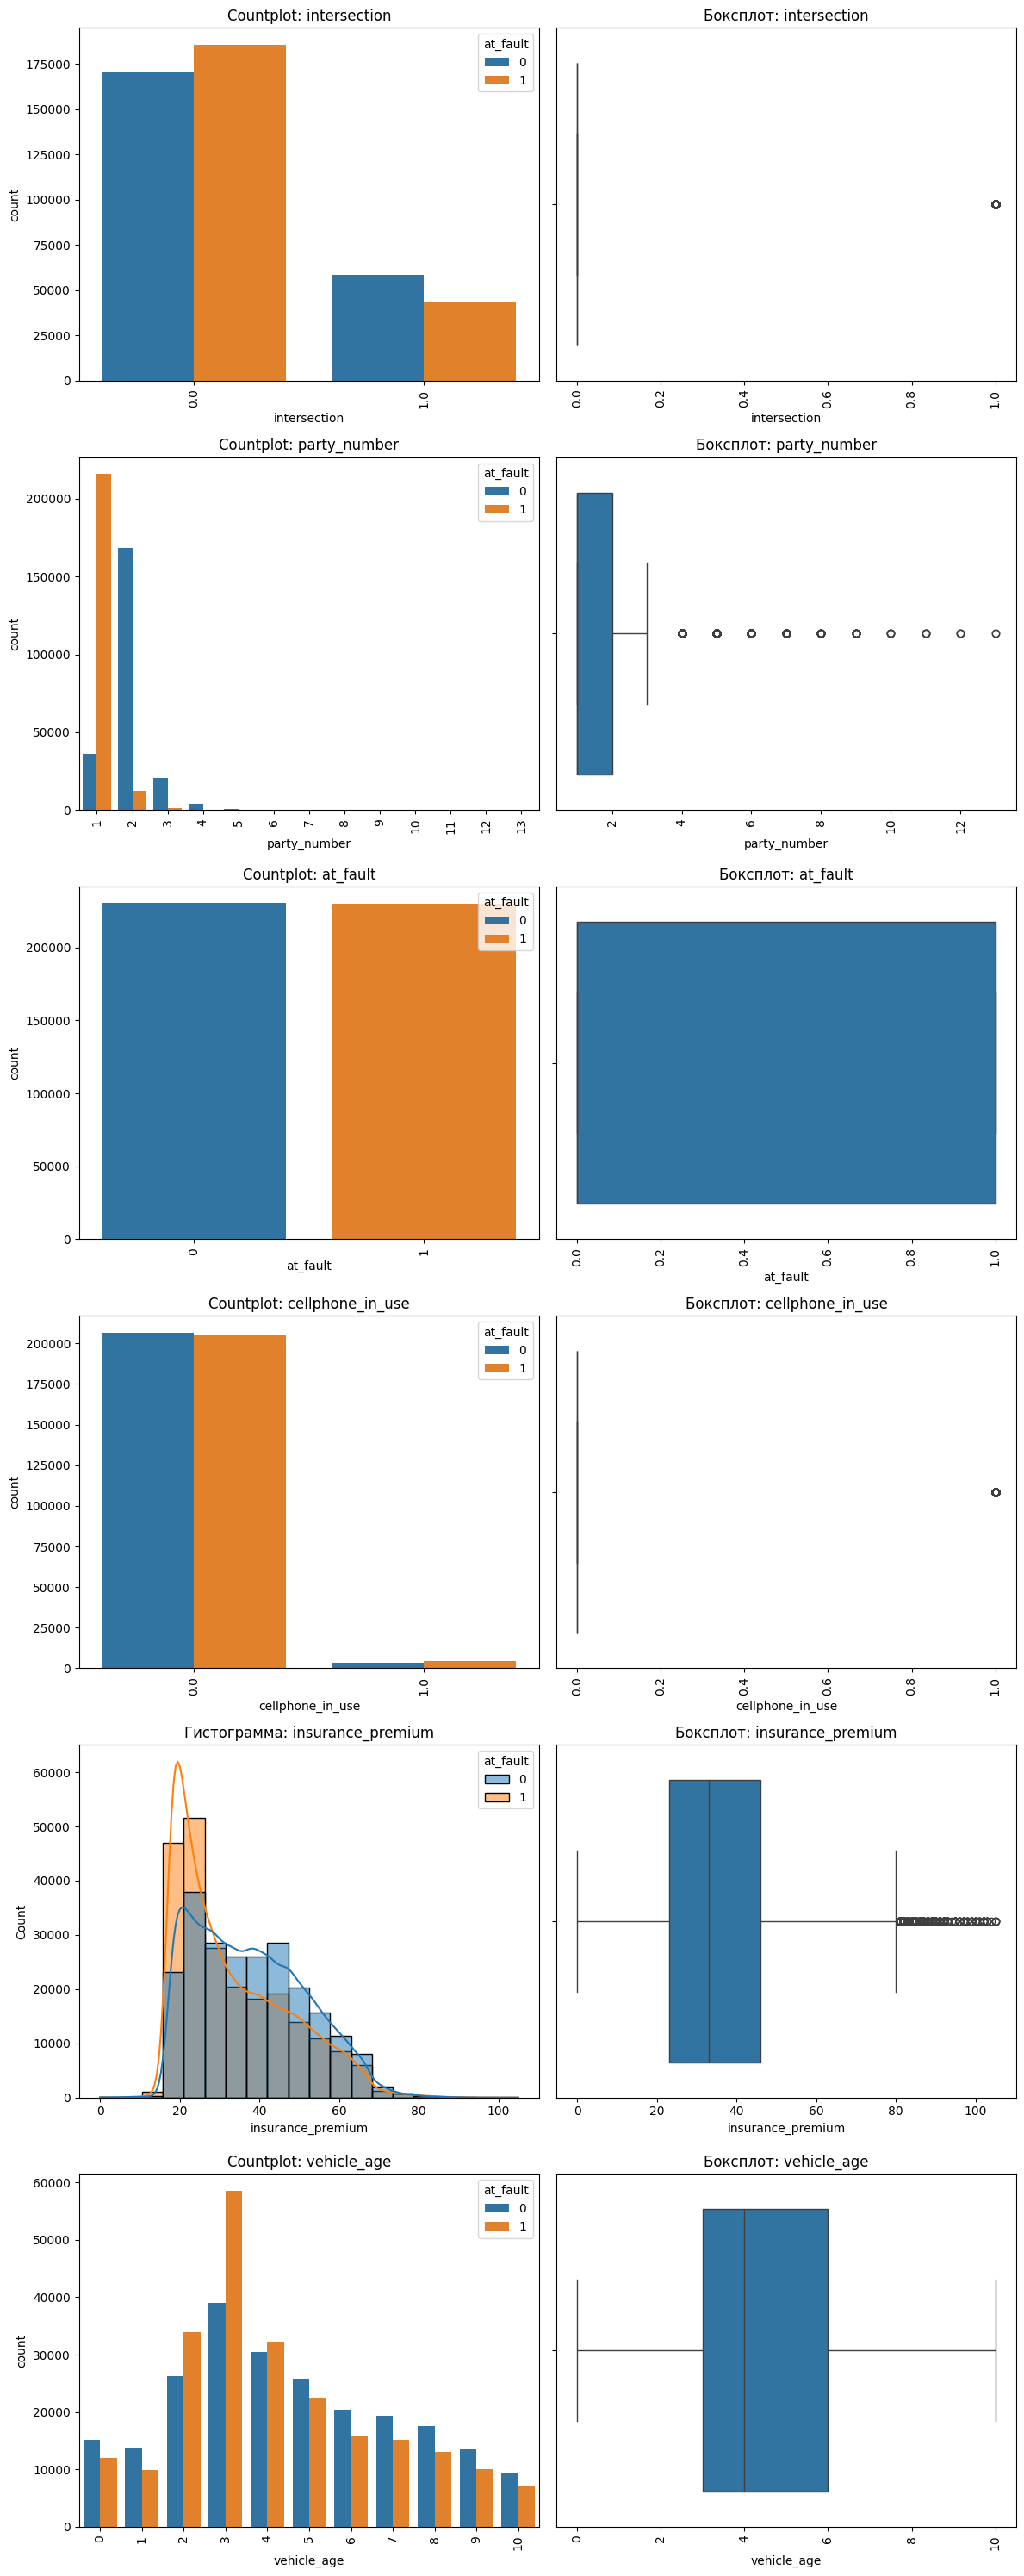

In [17]:
plot_combined(df, col=None, target='at_fault', col_type=None, legend_loc='best')

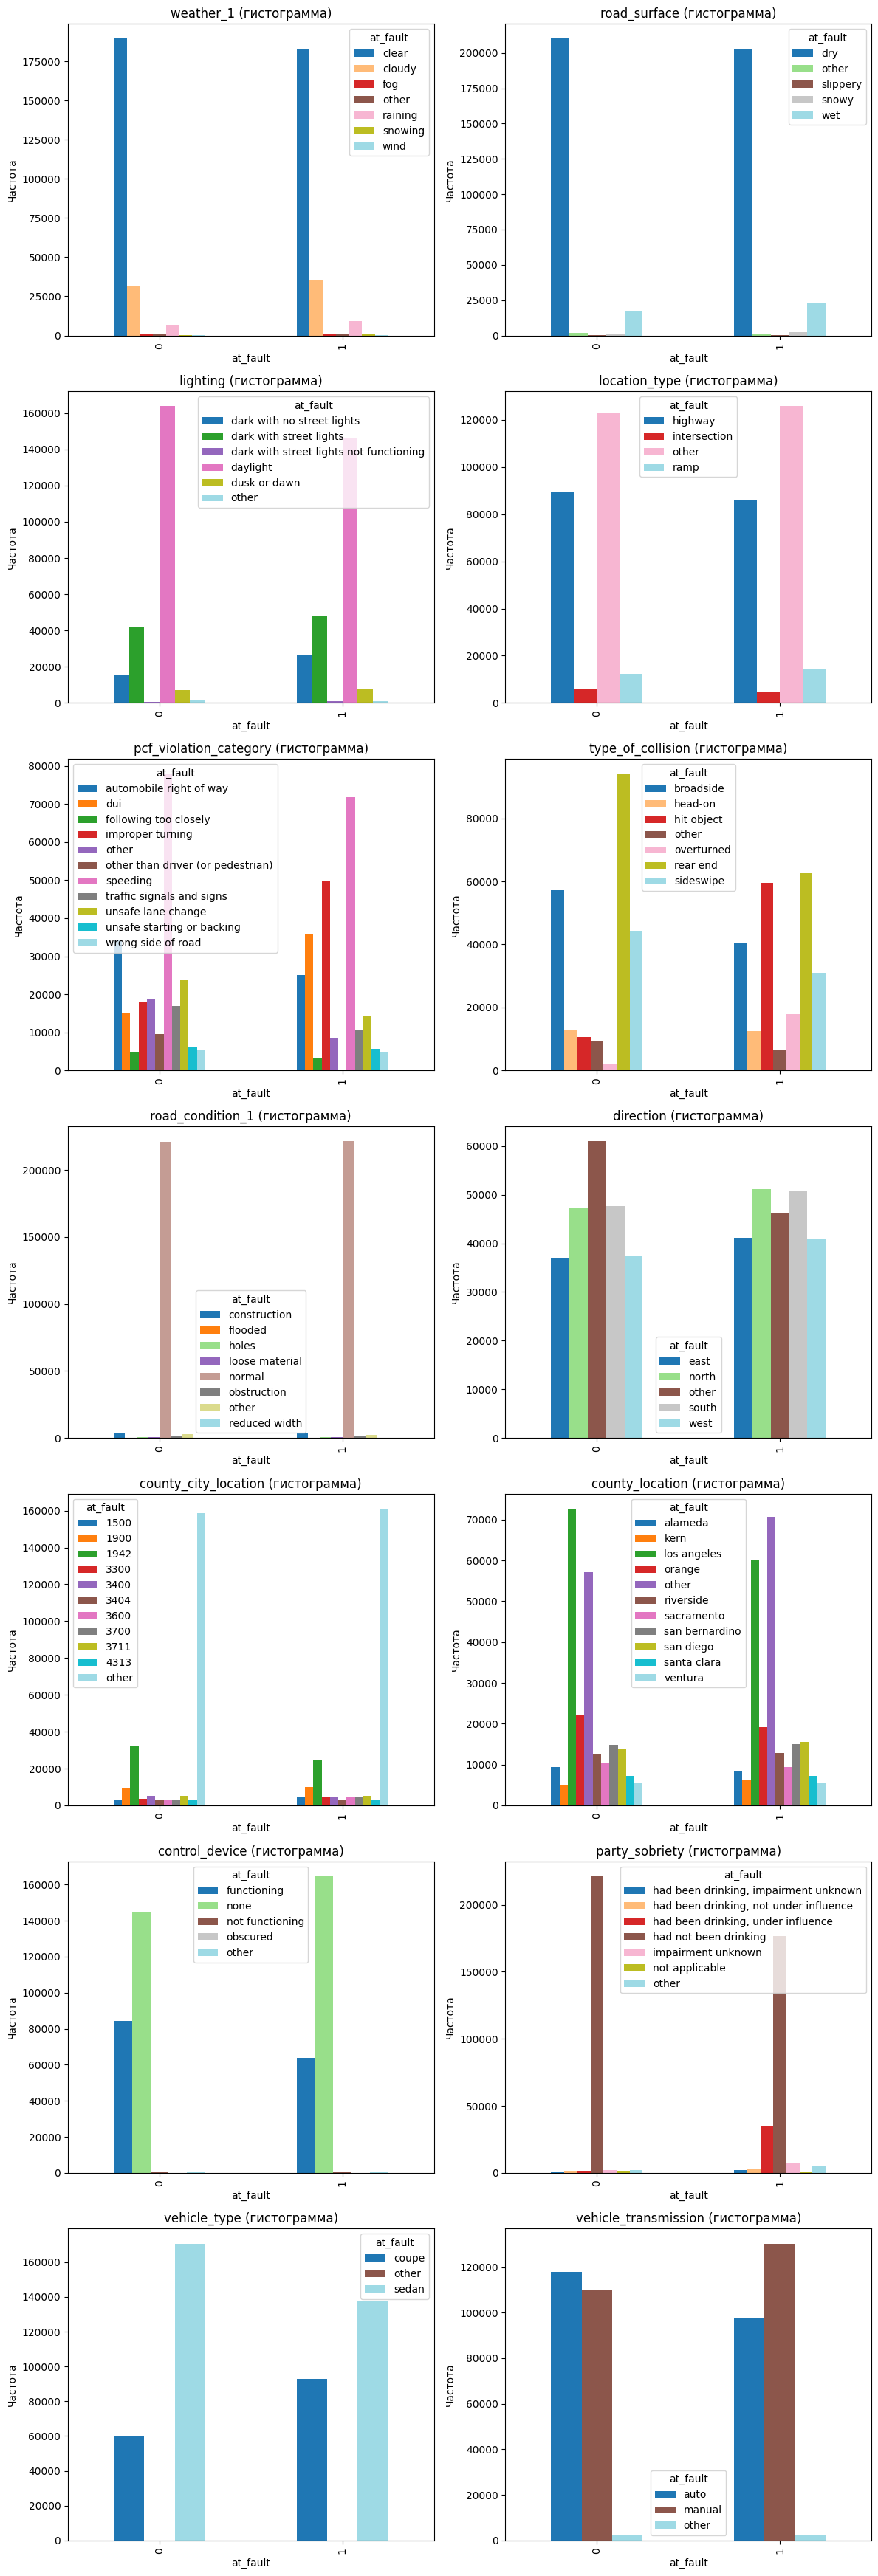

In [18]:
df_for_plot = df.drop(columns=['collision_date', 'collision_time'])
plot_categorical_columns(df_for_plot, col=None, target='at_fault', top_n=10)

In [19]:
# пока закоменчу, особой пользый не дает а ресурсы отжирает
# plot_scatter_with_numerical(df, target_column='at_fault')

### распределение по году

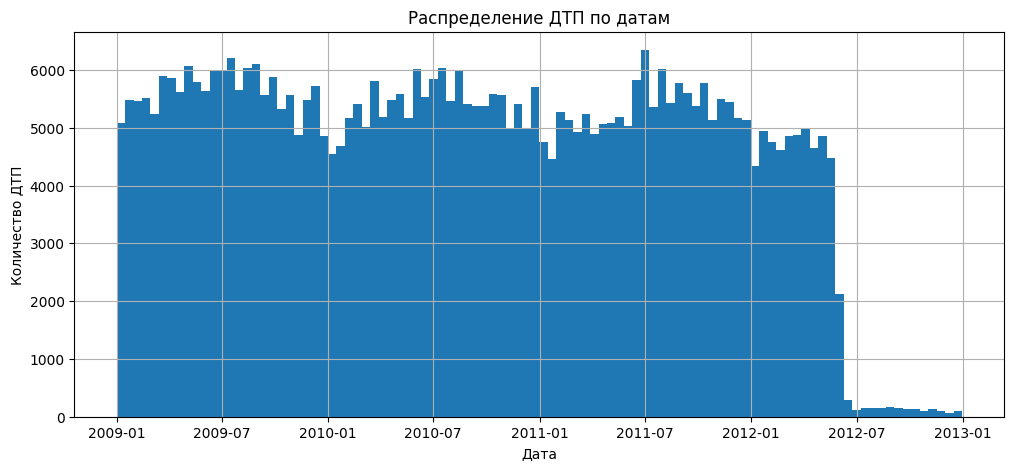

In [20]:
plt.figure(figsize=(12, 5))
df['collision_date'].hist(bins=100)
plt.title('Распределение ДТП по датам')
plt.xlabel('Дата')
plt.ylabel('Количество ДТП')
plt.show()

В целом видна цикличность возникновения дтп - летний период.

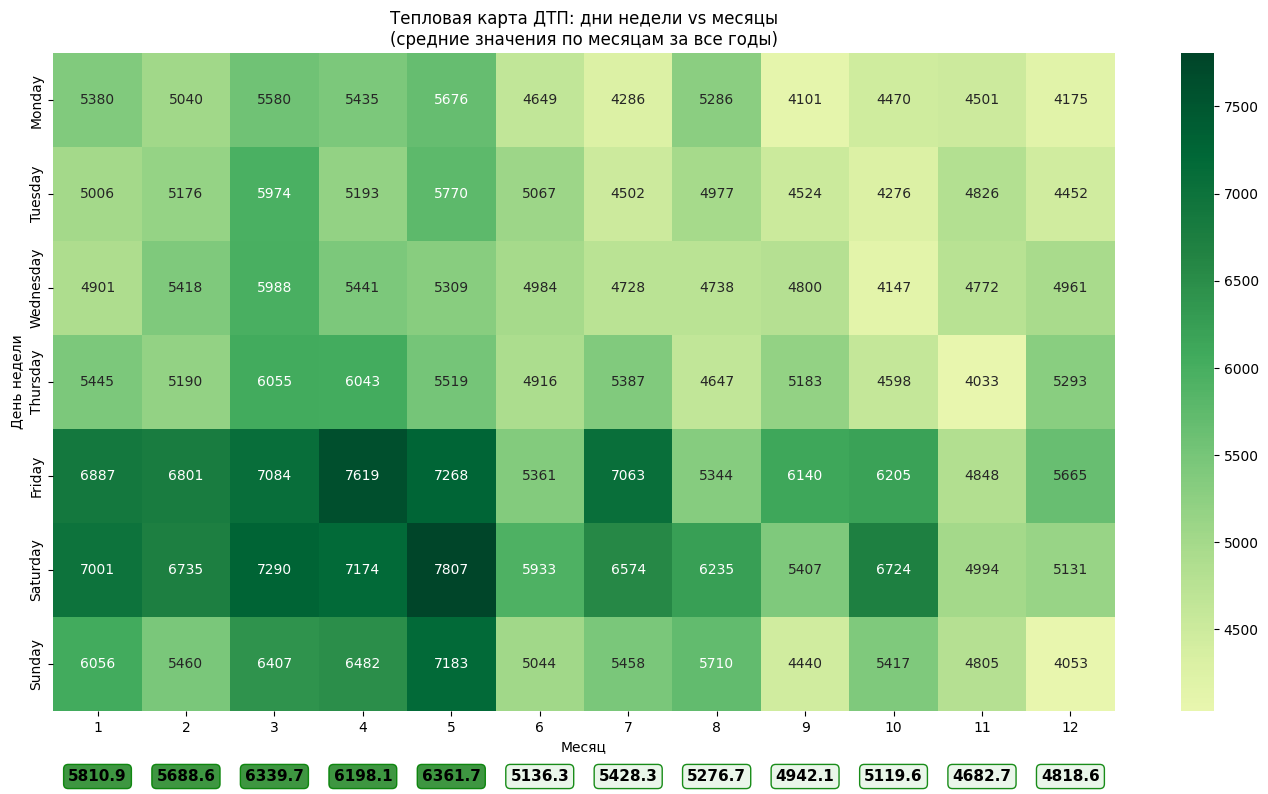

In [21]:
df['collision_date'] = pd.to_datetime(df['collision_date'])
df['collision_time'] = pd.to_datetime(df['collision_time'], format='%H:%M:%S')
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

pivot = df.groupby([df['collision_date'].dt.day_name(), df['collision_date'].dt.month]).size().unstack()
pivot = pivot.reindex(days_order)

plt.figure(figsize=(14, 8))
sns.heatmap(pivot, annot=True, fmt='d', cmap='YlGn', center=pivot.values.mean())

monthly_means = pivot.mean(axis=0)
mean_of_means = monthly_means.mean()

for i, (month, mean_val) in enumerate(monthly_means.items()):
    if mean_val < mean_of_means:
        # Более светлый зеленый для значений ниже среднего
        color = '#e8f5e8'
        text_color = "#000000"
    else:
        # Более насыщенный зеленый для значений выше среднего
        color = "#298b2c"
        text_color = "#000000"
    
    plt.text(i + 0.5, len(pivot) + 0.7, f'{mean_val:.1f}', 
             ha='center', va='center', fontweight='bold', fontsize=11,
             color=text_color,
             bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.9, edgecolor='green', linewidth=1))

plt.title('Тепловая карта ДТП: дни недели vs месяцы\n(средние значения по месяцам за все годы)')
plt.xlabel('Месяц')
plt.ylabel('День недели')
plt.tight_layout()
plt.show()

Что касается более детального распределения:  
1) Чаще всего дтп происходят в пятницу и субботу;  
2) И в зимне весенний период - зима скользко, весна - хочется думать уже о лете и голова забиты другими мыслями

### распределение по времени

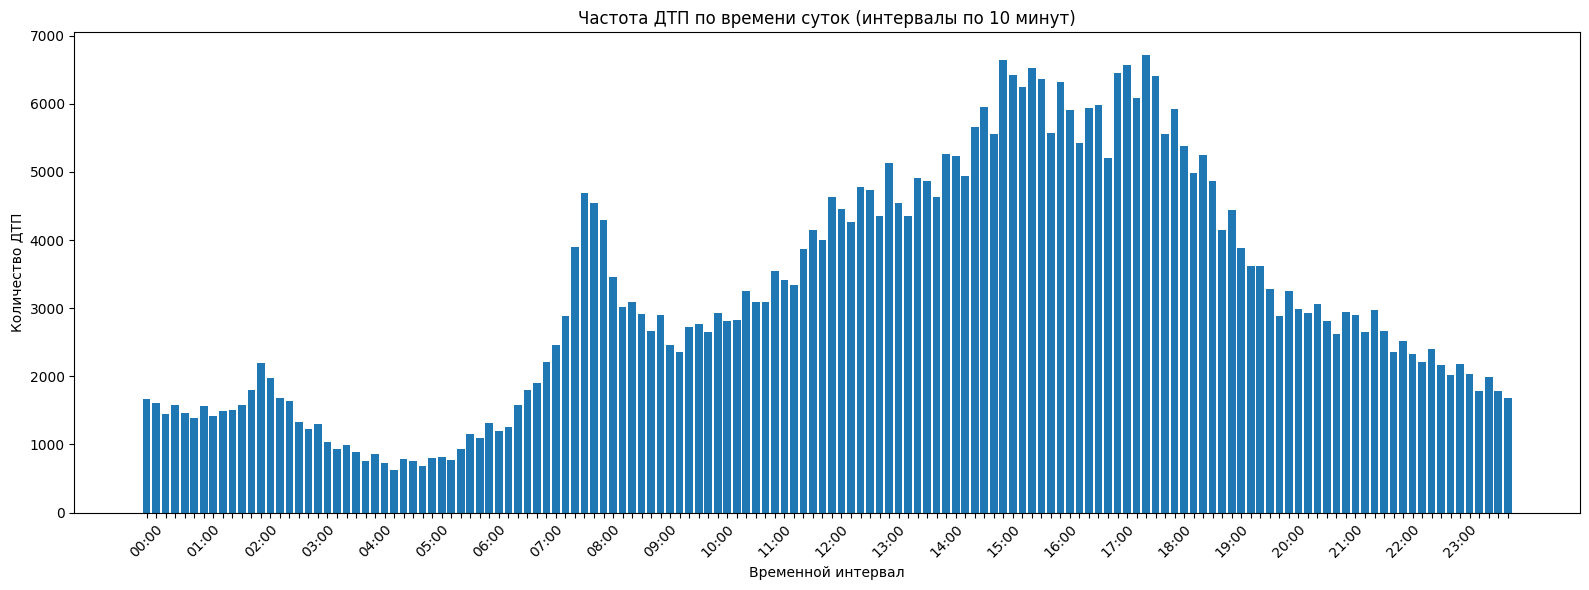

In [22]:
df_copy = df.copy()
df_copy['time_interval'] = pd.to_datetime(df_copy['collision_time'], format='%H:%M:%S').dt.floor('10min').dt.strftime('%H:%M')

plt.figure(figsize=(16, 6))
interval_counts = df_copy['time_interval'].value_counts().sort_index()

plt.bar(range(len(interval_counts)), interval_counts.values)
plt.title('Частота ДТП по времени суток (интервалы по 10 минут)')
plt.xlabel('Временной интервал')
plt.ylabel('Количество ДТП')

x_ticks = range(len(interval_counts))
x_labels = [label if i % 6 == 0 else '' for i, label in enumerate(interval_counts.index)]
plt.xticks(x_ticks, x_labels, rotation=45)

plt.tight_layout()
plt.show()

По времени ДТП также ситуация наглядная:  
1) Утренник часпик когда все едут на работу;  
2) И плавный рост после 15:00 и до вечернего часпика когда все едут домой.

In [23]:
# создаем новые признаки из даты и времени
# день месяца, день недели и час
df['day_of_month'] = df['collision_date'].dt.day
df['day_of_week'] = df['collision_date'].dt.dayofweek
df['hour'] = df['collision_time'].dt.hour

In [24]:
for col in df.columns:
    if df[col].dtype == 'object' or df[col].dtype.name == 'category':
        df[col] = df[col].fillna('unknown')
    elif np.issubdtype(df[col].dtype, np.number):
        df[col] = df[col].fillna(-1)

np.int64(7)

'Удаляем'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460623 entries, 0 to 460622
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   weather_1               460623 non-null  object        
 1   road_surface            460623 non-null  object        
 2   lighting                460623 non-null  object        
 3   intersection            460623 non-null  float64       
 4   location_type           460623 non-null  object        
 5   pcf_violation_category  460623 non-null  object        
 6   type_of_collision       460623 non-null  object        
 7   road_condition_1        460623 non-null  object        
 8   direction               460623 non-null  object        
 9   collision_date          460623 non-null  datetime64[ns]
 10  collision_time          459992 non-null  datetime64[ns]
 11  county_city_location    460623 non-null  object        
 12  county_location         460623

None

,weather_1,road_surface,lighting,intersection,location_type,pcf_violation_category,type_of_collision,road_condition_1,direction,collision_date,...,at_fault,party_sobriety,cellphone_in_use,insurance_premium,vehicle_type,vehicle_age,vehicle_transmission,day_of_month,day_of_week,hour
330585,clear,dry,daylight,0.0,unknown,other equipment,hit object,normal,east,2011-12-21,...,1,had not been drinking,0.0,24.0,sedan,8,manual,21,2,8.0
218572,clear,dry,daylight,0.0,unknown,improper turning,sideswipe,normal,south,2011-11-25,...,0,had not been drinking,0.0,31.0,coupe,5,manual,25,4,13.0
200736,clear,dry,daylight,0.0,highway,speeding,rear end,normal,east,2010-12-30,...,0,had not been drinking,0.0,53.0,sedan,2,auto,30,3,13.0
291729,clear,dry,dark with street lights,0.0,unknown,dui,rear end,normal,east,2011-12-08,...,0,had not been drinking,0.0,37.0,sedan,2,auto,8,3,19.0
72879,clear,dry,daylight,0.0,highway,speeding,rear end,normal,south,2009-08-14,...,0,had not been drinking,0.0,36.0,sedan,5,manual,14,4,13.0


collision_time    631
dtype: int64

None

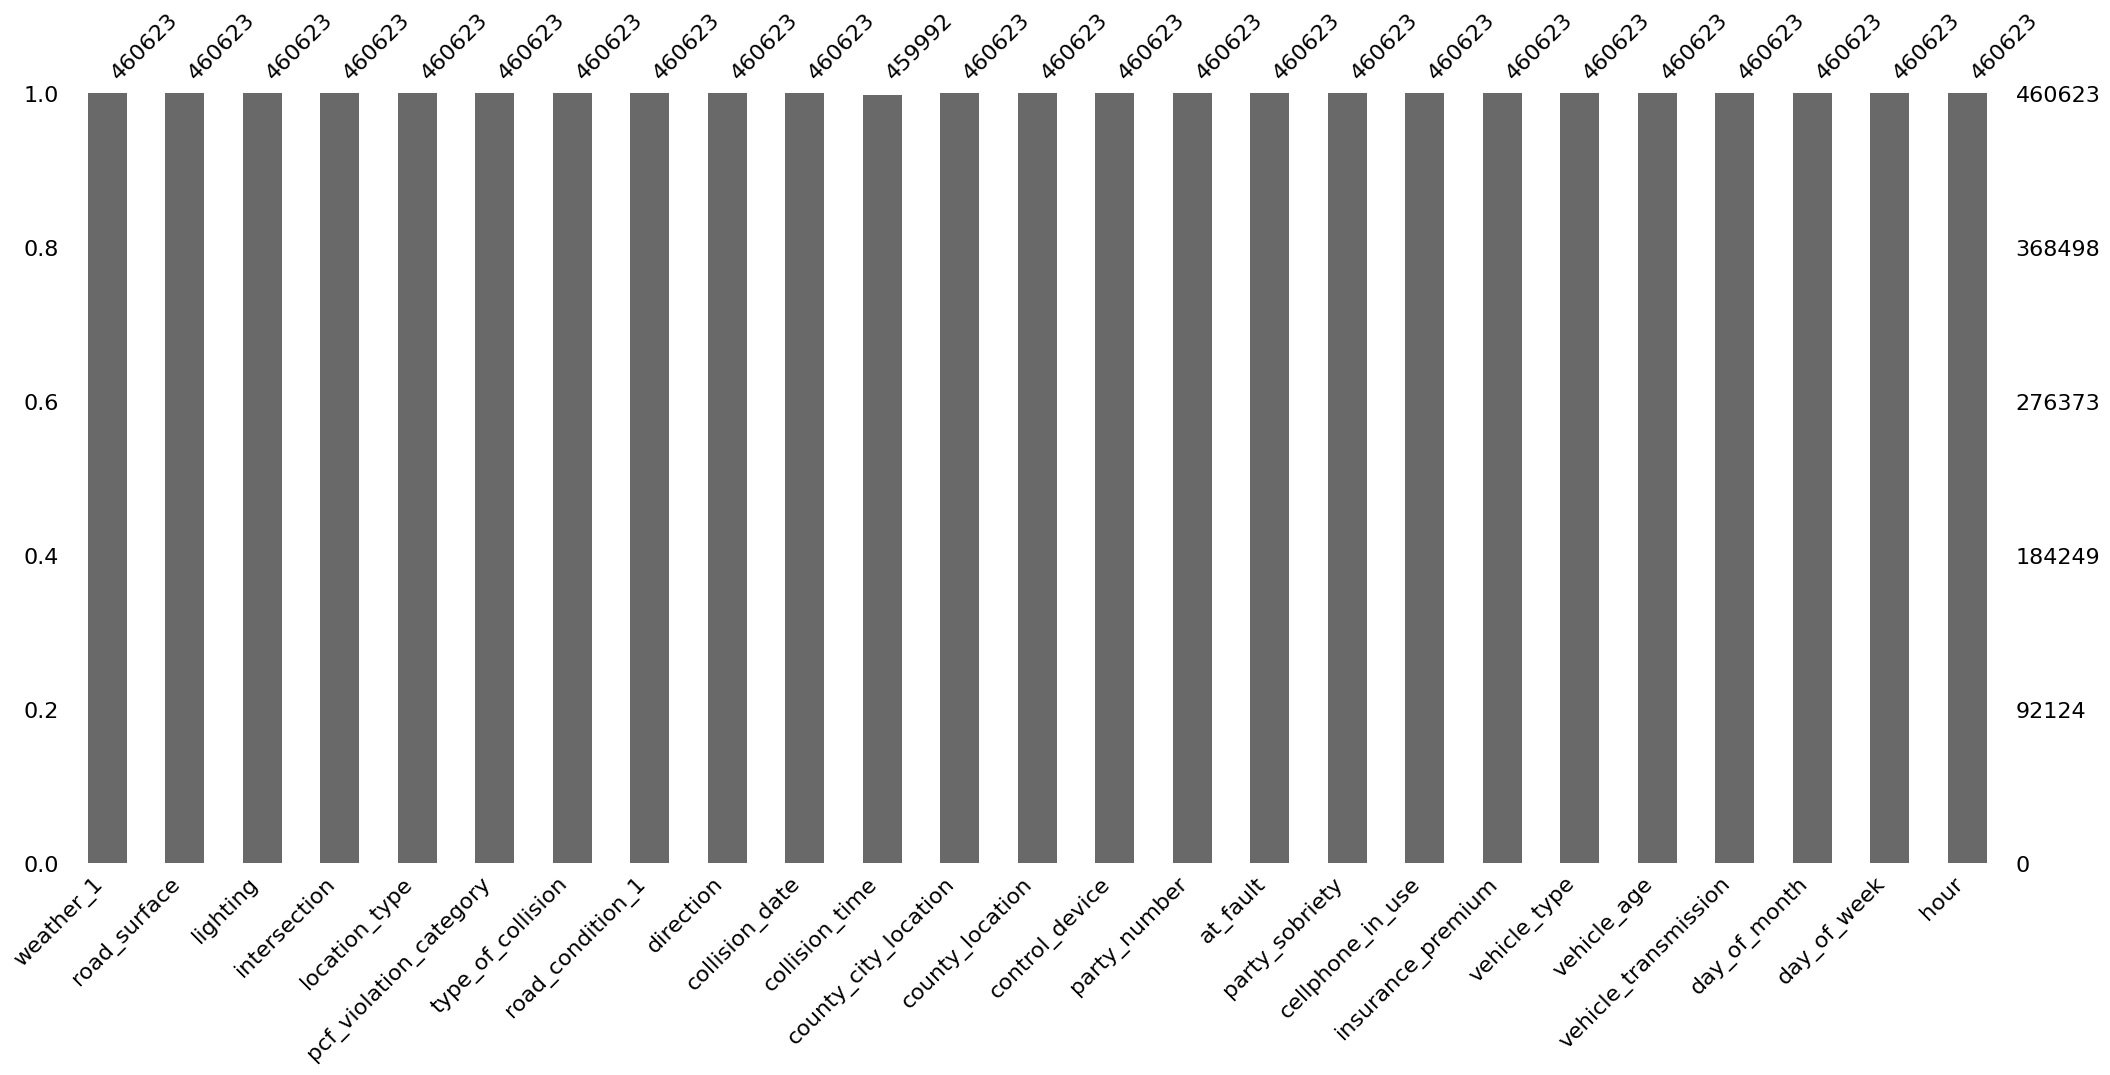

,count,mean,min,25%,50%,75%,max,std
intersection,460623.0,0.21701,-1.0,0.0,0.0,0.0,1.0,0.422617
collision_date,460623,2010-09-05 15:33:49.834376448,2009-01-01 00:00:00,2009-10-22 00:00:00,2010-08-29 00:00:00,2011-07-15 00:00:00,2012-12-30 00:00:00,NaN
collision_time,459992,1900-01-01 13:51:19.788082432,1900-01-01 00:00:00,1900-01-01 10:17:00,1900-01-01 14:45:00,1900-01-01 17:51:00,1900-01-01 23:59:00,NaN
party_number,460623.0,1.526546,1.0,1.0,1.0,2.0,13.0,0.663029
at_fault,460623.0,0.499719,0.0,0.0,0.0,1.0,1.0,0.5
cellphone_in_use,460623.0,-0.071306,-1.0,0.0,0.0,0.0,1.0,0.318167
insurance_premium,460623.0,35.09968,-1.0,23.0,32.0,46.0,105.0,14.577237
vehicle_age,460623.0,4.356843,0.0,3.0,4.0,6.0,10.0,2.592554
day_of_month,460623.0,15.656661,1.0,8.0,16.0,23.0,31.0,8.778735
day_of_week,460623.0,3.161586,0.0,1.0,3.0,5.0,6.0,1.975313


In [25]:
# проверяем результат
drop_duplicated(df)
df = check_data(df)

### кореляция с таргетом

'=== Корреляция с таргетом ==='

party_number             -0.687133
insurance_premium        -0.166025
vehicle_type             -0.152896
pcf_violation_category   -0.126863
party_sobriety           -0.108687
lighting                 -0.090435
vehicle_transmission      0.085595
hour                     -0.083977
control_device            0.083398
type_of_collision        -0.081849
intersection             -0.077947
vehicle_age              -0.069907
road_surface              0.047352
direction                -0.032244
weather_1                 0.029650
county_city_location      0.023450
day_of_week               0.019754
location_type             0.017847
day_of_month              0.001504
cellphone_in_use          0.000549
road_condition_1         -0.000335
Name: at_fault, dtype: float64

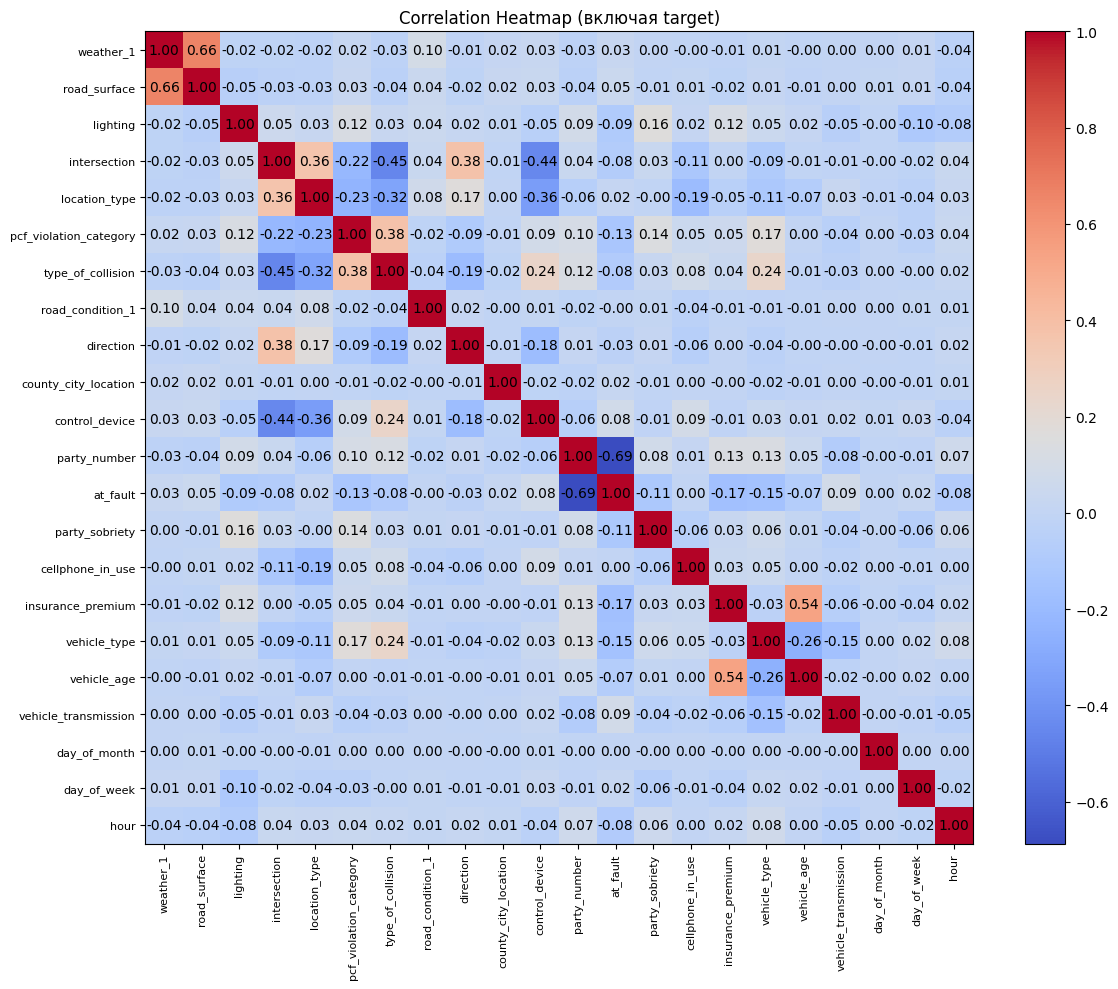

'=== VIF ==='

,feature,VIF
6,type_of_collision,2.222408
3,intersection,2.128287
0,weather_1,2.018521
1,road_surface,1.983021
5,pcf_violation_category,1.719869
10,control_device,1.679595
4,location_type,1.650287
15,vehicle_type,1.640346
17,vehicle_transmission,1.594020
11,party_number,1.565025


In [26]:
df_cor = df.drop(columns=['collision_date', 'collision_time', 'county_location'])
calc_target_correlations(df_cor, target_col="at_fault")

# Обучение модели

In [27]:
# для модели нам нужен только 2012 год
# df = df[df['collision_date'].between('2012-01-01', '2012-12-31')]
df = df[df['collision_date'].between('2012-01-01', '2012-05-31')]

# уберем утечки и лишние данные
columns_to_drop = [
    'party_sobriety',
    'pcf_violation_category', 
    'type_of_collision',
    'collision_date',
    'collision_time',
    'party_number',
    'county_location'
]

df = df.drop(columns=columns_to_drop)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48648 entries, 73 to 460622
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   weather_1             48648 non-null  object 
 1   road_surface          48648 non-null  object 
 2   lighting              48648 non-null  object 
 3   intersection          48648 non-null  float64
 4   location_type         48648 non-null  object 
 5   road_condition_1      48648 non-null  object 
 6   direction             48648 non-null  object 
 7   county_city_location  48648 non-null  object 
 8   control_device        48648 non-null  object 
 9   at_fault              48648 non-null  int64  
 10  cellphone_in_use      48648 non-null  float64
 11  insurance_premium     48648 non-null  float64
 12  vehicle_type          48648 non-null  object 
 13  vehicle_age           48648 non-null  int64  
 14  vehicle_transmission  48648 non-null  object 
 15  day_of_month          

In [29]:
# возьмем часть данных для подбора гиперпараметров и финального теста
df_rest, df_test = train_test_split(
    df, 
    test_size=0.05, 
    stratify=df['at_fault'], 
    random_state=RANDOM_STATE
)

logger.info("Распределение таргета:")
logger.info(f"Тест: {df_test['at_fault'].value_counts(normalize=True)}")
logger.info(f"Остальные: {df_rest['at_fault'].value_counts(normalize=True)}")

2025-11-28 10:06:53 [INFO] __main__: Распределение таргета:
2025-11-28 10:06:53 [INFO] __main__: Тест: at_fault
1    0.502261
0    0.497739
Name: proportion, dtype: float64
2025-11-28 10:06:53 [INFO] __main__: Остальные: at_fault
1    0.502326
0    0.497674
Name: proportion, dtype: float64


In [30]:
# разделим на выборки их оставшихся данных
X_train, X_val, y_train, y_val = train_test_split(
    df_rest.drop(['at_fault'], axis=1),
    df_rest['at_fault'],
    test_size=TEST_SIZE,
    stratify=df_rest['at_fault'],
    random_state=RANDOM_STATE
)

# финальный отложенный тест
X_final_test = df_test.drop(['at_fault'], axis=1)
y_final_test = df_test['at_fault']

logger.info(f"Размеры выборок: Train={X_train.shape}, Val={X_val.shape}, Test={X_final_test.shape}")
logger.info(f"Распределение таргета - Train: {y_train.value_counts(normalize=True).to_dict()}")

2025-11-28 10:06:53 [INFO] __main__: Размеры выборок: Train=(34661, 17), Val=(11554, 17), Test=(2433, 17)
2025-11-28 10:06:53 [INFO] __main__: Распределение таргета - Train: {1: 0.5023224950232249, 0: 0.49767750497677504}


In [31]:
# сюда будем писать результаты
results = {}

# разделяем признаки
cat_selector = make_column_selector(dtype_include=["object", "category", "bool"])
num_selector = make_column_selector(dtype_include=[np.number])

# циклические признаки
cic = ['day_of_month', 'day_of_week', 'hour']
cyclic_cols = [c for c in cic if c in X_train.columns]

cat_cols = cat_selector(X_train)
num_cols = [c for c in num_selector(X_train) if c not in cyclic_cols]

if not cyclic_cols:
    logger.warning(f"Циклические признаки {cic} не найдены в данных")

display("Категориальные:", cat_cols)
display("Числовые:", num_cols)
display("Циклические:", cyclic_cols)
logger.info(f"Всего: {len(cat_cols)} категориальных, {len(num_cols)} числовых, {len(cyclic_cols)} циклических")

'Категориальные:'

['weather_1',
 'road_surface',
 'lighting',
 'location_type',
 'road_condition_1',
 'direction',
 'county_city_location',
 'control_device',
 'vehicle_type',
 'vehicle_transmission']

'Числовые:'

['intersection', 'cellphone_in_use', 'insurance_premium', 'vehicle_age']

'Циклические:'

['day_of_month', 'day_of_week', 'hour']

2025-11-28 10:06:53 [INFO] __main__: Всего: 10 категориальных, 4 числовых, 3 циклических


In [32]:
to_str = FunctionTransformer(lambda x: x.astype(str))

def create_cyclic_features(X):
    out = pd.DataFrame(index=X.index)

    if 'hour' in X.columns:
        out['hour_sin'] = np.sin(2 * np.pi * X['hour'] / 24)
        out['hour_cos'] = np.cos(2 * np.pi * X['hour'] / 24)
    
    if 'day_of_week' in X.columns:
        out['day_of_week_sin'] = np.sin(2 * np.pi * X['day_of_week'] / 7)
        out['day_of_week_cos'] = np.cos(2 * np.pi * X['day_of_week'] / 7)
    
    if 'day_of_month' in X.columns:
        # Предполагаем максимальную длину месяца 31 день
        out['day_of_month_sin'] = np.sin(2 * np.pi * X['day_of_month'] / 31)
        out['day_of_month_cos'] = np.cos(2 * np.pi * X['day_of_month'] / 31)

    return out

def cyclic_feature_names_out(transformer, input_features):
    features = []
    if 'hour' in input_features:
        features.extend(['hour_sin', 'hour_cos'])
    if 'day_of_week' in input_features:
        features.extend(['day_of_week_sin', 'day_of_week_cos'])
    if 'day_of_month' in input_features:
        features.extend(['day_of_month_sin', 'day_of_month_cos'])
    return np.array(features)

cyclic_transformer = FunctionTransformer(
    func=create_cyclic_features,
    feature_names_out=cyclic_feature_names_out,
    validate=False
)

In [33]:
# Для линейных моделей
preprocessor_linear = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cyclic", Pipeline([
            ("cyclic", cyclic_transformer),
            ("scaler", StandardScaler())
        ]), cyclic_cols),
        ("cat", Pipeline([
            ("to_str", to_str),
            ("ohe", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False))
        ]), cat_cols)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# Для деревьев и бустингов
preprocessor_tree = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cyclic", cyclic_transformer, cyclic_cols),
        ("cat", Pipeline([
            ("to_str", to_str),
            ("ohe", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False))
        ]), cat_cols)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

In [34]:
models = {
    "LogisticRegression": (lambda: LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, class_weight="balanced"), preprocessor_linear),
    "DecisionTree": (lambda: DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight="balanced"), preprocessor_tree),
    "RandomForest": (lambda: RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=N_JOBS, class_weight="balanced"), preprocessor_tree),
    "LightGBM": (lambda: LGBMClassifier(random_state=RANDOM_STATE, n_jobs=N_JOBS, verbosity=-1), preprocessor_tree)
}

In [35]:
param_grid = {
    "LogisticRegression": {
        "C": (0.001, 10, "log")
    },
    "RandomForest": {
        "n_estimators": (100, 1000, 100),
        "max_depth": (3, 15),
        "min_samples_split": (2, 15),
        "min_samples_leaf": (1, 5),
        "max_features": ["sqrt", "log2"]
    },
    "DecisionTree": {
        "max_depth": (3, 15),
        "min_samples_split": (2, 15),
        "min_samples_leaf": (1, 5),
        "max_features": ["sqrt", "log2"]
    },
    "LightGBM": {
        "n_estimators": (100, 1000, 100),
        "max_depth": (3, 15),
        "learning_rate": (0.01, 0.3, "log"),
        "num_leaves": (20, 128),
        "min_child_samples": (10, 60)
    }
}

In [36]:
def objective_model(trial, model_name, preprocessor):
    k_max = min(100, X_train.shape[1])
    k_best = trial.suggest_int("selectkbest__k", 10, k_max)

    pgrid = param_grid[model_name]

    if model_name == "LogisticRegression":
        C = suggest_param(trial, "C", pgrid["C"])
        model = LogisticRegression(
            C=C,
            random_state=RANDOM_STATE,
            max_iter=1000,
            class_weight="balanced"
        )

    elif model_name in ["RandomForest", "DecisionTree"]:
        cls = RandomForestClassifier if model_name == "RandomForest" else DecisionTreeClassifier
        model_params = {}
        for key, spec in pgrid.items():
            model_params[key] = suggest_param(trial, key, spec)
        model_params["random_state"] = RANDOM_STATE
        if model_name == "RandomForest":
            model_params["n_jobs"] = N_JOBS
        model_params["class_weight"] = "balanced"
        model = cls(**model_params)

    elif model_name == "LightGBM":
        model_params = {}
        for key, spec in pgrid.items():
            model_params[key] = suggest_param(trial, key, spec)
        model_params["random_state"] = RANDOM_STATE
        model_params["n_jobs"] = N_JOBS
        model_params["verbosity"] = -1
        model_params["class_weight"] = "balanced"
        model = LGBMClassifier(**model_params)

    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("selectkbest", SelectKBest(score_func=f_classif, k=k_best)),
        ("classifier", model)
    ])

    # Обучаем на X_train, валидируем на X_val
    pipeline.fit(X_train, y_train)
    
    X_train_transformed = preprocessor.transform(X_train)
    logger.debug(f"После препроцессинга: {X_train_transformed.shape}")
    
    selector_step = pipeline.named_steps["selectkbest"]
    logger.debug(f"SelectKBest выбрал: {selector_step.k} признаков")
    
    y_pred = pipeline.predict(X_val)
    f1 = f1_score(y_val, y_pred)

    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    return f1

Для оптимизации моделей будем использовать F1 метрику, потому, что нам важно предупредить водителя, что на данном участке может быть ДТП.  
Если бы нам важно было бы именно избежать ДТП в любом случае, то правильнее было бы уже использовать F2 метрику с повышенной beta, т.е. ложные сработки не критичны, главное точно предсказать, что будет ДТП.

## Подбор лучшей модели

In [37]:
best_models = {}
study_results = []

early_stop_cb = EarlyStoppingCallback(patience=EARLY_STOP)

def log_every_N_trials(study, trial, N=100):
    if trial.number % N == 0:
        best_trial = study.best_trial
        logger.info(
            f"[Trial {trial.number} finished]. Trial {best_trial.number} is best: F1={best_trial.value:.4f}, params={best_trial.params}"
        )

for model_name, (model_factory, preprocessor) in models.items():
    logger.info(f"\n\n=== Optimizing {model_name} ===")

    pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=0)
    study = optuna.create_study(direction="maximize", pruner=pruner)

    study.optimize(
        lambda trial: objective_model(trial, model_name, preprocessor),
        n_trials=N_ITER,
        callbacks=[log_every_N_trials, early_stop_cb]
    )

    best_params = study.best_params
    best_value = study.best_value
    logger.info(f"Best trial {study.best_trial.number} -> F1={best_value:.4f}, params={best_params}")

    k_best_final = best_params.get("selectkbest__k", X_train.shape[1])

    if model_name == "LogisticRegression":
        C = best_params.get("C", 1.0)
        best_model = LogisticRegression(
            C=C,
            random_state=RANDOM_STATE,
            max_iter=1000,
            class_weight="balanced"
        )

    elif model_name in ["RandomForest", "DecisionTree"]:
        cls = RandomForestClassifier if model_name == "RandomForest" else DecisionTreeClassifier
        model_params = {}
        for key, spec in param_grid[model_name].items():
            if key in best_params:
                model_params[key] = best_params[key]
            else:
                model_params[key] = spec[0] if isinstance(spec, tuple) else spec[0] if isinstance(spec, list) else spec
        model_params["random_state"] = RANDOM_STATE
        if model_name == "RandomForest":
            model_params["n_jobs"] = N_JOBS
        model_params["class_weight"] = "balanced"
        best_model = cls(**model_params)

    elif model_name == "LightGBM":
        model_params = {}
        for key, spec in param_grid[model_name].items():
            if key in best_params:
                model_params[key] = best_params[key]
            else:
                model_params[key] = spec[0] if isinstance(spec, tuple) else spec[0] if isinstance(spec, list) else spec
        model_params["random_state"] = RANDOM_STATE
        model_params["n_jobs"] = N_JOBS
        model_params["verbosity"] = -1
        model_params["class_weight"] = "balanced"
        best_model = LGBMClassifier(**model_params)

    final_pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("selectkbest", SelectKBest(score_func=f_classif, k=k_best_final)),
        ("classifier", best_model)
    ])

    final_pipe.fit(X_train, y_train)
    best_models[model_name] = final_pipe

    study_results.append({
        "Model": model_name,
        "Best_params": best_params,
        "F1_CV": best_value
    })

2025-11-28 10:06:53 [INFO] __main__: 

=== Optimizing LogisticRegression ===
2025-11-28 10:06:54 [INFO] __main__: [Trial 0 finished]. Trial 0 is best: F1=0.6171, params={'selectkbest__k': 16, 'C': 0.001833253074208401}
2025-11-28 10:06:55 [INFO] func: Ранняя остановка: нет улучшений 2 trials
2025-11-28 10:06:55 [INFO] __main__: Best trial 0 -> F1=0.6171, params={'selectkbest__k': 16, 'C': 0.001833253074208401}
2025-11-28 10:06:56 [INFO] __main__: 

=== Optimizing DecisionTree ===
2025-11-28 10:06:56 [INFO] __main__: [Trial 0 finished]. Trial 0 is best: F1=0.5973, params={'selectkbest__k': 16, 'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'log2'}
2025-11-28 10:06:56 [INFO] func: Ранняя остановка: нет улучшений 2 trials
2025-11-28 10:06:56 [INFO] __main__: Best trial 0 -> F1=0.5973, params={'selectkbest__k': 16, 'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'log2'}
2025-11-28 10:06:57 [INFO] __main__: 

=== Optimizing Ra

## Сравнение результатов

2025-11-28 10:07:16 [INFO] __main__: 

=== LogisticRegression ===


,0,1
0,744,467
1,439,783


2025-11-28 10:07:16 [INFO] __main__: ROC_AUC: 0.6749
2025-11-28 10:07:16 [INFO] __main__: Accuracy: 0.6276
2025-11-28 10:07:16 [INFO] __main__: F1 Score: 0.6335
2025-11-28 10:07:16 [INFO] __main__: Precision: 0.6264
2025-11-28 10:07:16 [INFO] __main__: Recall: 0.6408
2025-11-28 10:07:16 [INFO] __main__: --------------------------------------------------
2025-11-28 10:07:16 [INFO] __main__: 

=== DecisionTree ===


,0,1
0,821,390
1,536,686


2025-11-28 10:07:16 [INFO] __main__: ROC_AUC: 0.6566
2025-11-28 10:07:16 [INFO] __main__: Accuracy: 0.6194
2025-11-28 10:07:16 [INFO] __main__: F1 Score: 0.5970
2025-11-28 10:07:16 [INFO] __main__: Precision: 0.6375
2025-11-28 10:07:16 [INFO] __main__: Recall: 0.5614
2025-11-28 10:07:16 [INFO] __main__: --------------------------------------------------
2025-11-28 10:07:16 [INFO] __main__: 

=== RandomForest ===


,0,1
0,813,398
1,476,746


2025-11-28 10:07:16 [INFO] __main__: ROC_AUC: 0.6864
2025-11-28 10:07:16 [INFO] __main__: Accuracy: 0.6408
2025-11-28 10:07:16 [INFO] __main__: F1 Score: 0.6306
2025-11-28 10:07:16 [INFO] __main__: Precision: 0.6521
2025-11-28 10:07:16 [INFO] __main__: Recall: 0.6105
2025-11-28 10:07:16 [INFO] __main__: --------------------------------------------------
2025-11-28 10:07:16 [INFO] __main__: 

=== LightGBM ===


,0,1
0,794,417
1,481,741


2025-11-28 10:07:16 [INFO] __main__: ROC_AUC: 0.6775
2025-11-28 10:07:16 [INFO] __main__: Accuracy: 0.6309
2025-11-28 10:07:16 [INFO] __main__: F1 Score: 0.6227
2025-11-28 10:07:16 [INFO] __main__: Precision: 0.6399
2025-11-28 10:07:16 [INFO] __main__: Recall: 0.6064
2025-11-28 10:07:16 [INFO] __main__: --------------------------------------------------


,Model,Best_params,F1_CV,ROC_AUC_Val,ROC_AUC_FinalTest,F1_Val,F1_FinalTest,Accuracy_Val,Accuracy_FinalTest,Precision_Val,Precision_FinalTest,Recall_Val,Recall_FinalTest
0,LogisticRegression,"{'selectkbest__k': 16, 'C': 0.001833253074208401}",0.617137,0.664024,0.674852,0.617137,0.633495,0.621776,0.627620,0.627807,0.626400,0.606823,0.640753
2,RandomForest,"{'selectkbest__k': 13, 'n_estimators': 400, 'm...",0.628798,0.686148,0.686385,0.628798,0.630600,0.643673,0.640773,0.659542,0.652098,0.600793,0.610475
3,LightGBM,"{'selectkbest__k': 17, 'n_estimators': 900, 'm...",0.626352,0.680801,0.677480,0.626352,0.622689,0.641163,0.630908,0.656652,0.639896,0.598725,0.606383
1,DecisionTree,"{'selectkbest__k': 16, 'max_depth': 4, 'min_sa...",0.597322,0.657655,0.656578,0.597322,0.597041,0.627748,0.619400,0.654091,0.637546,0.549621,0.561375


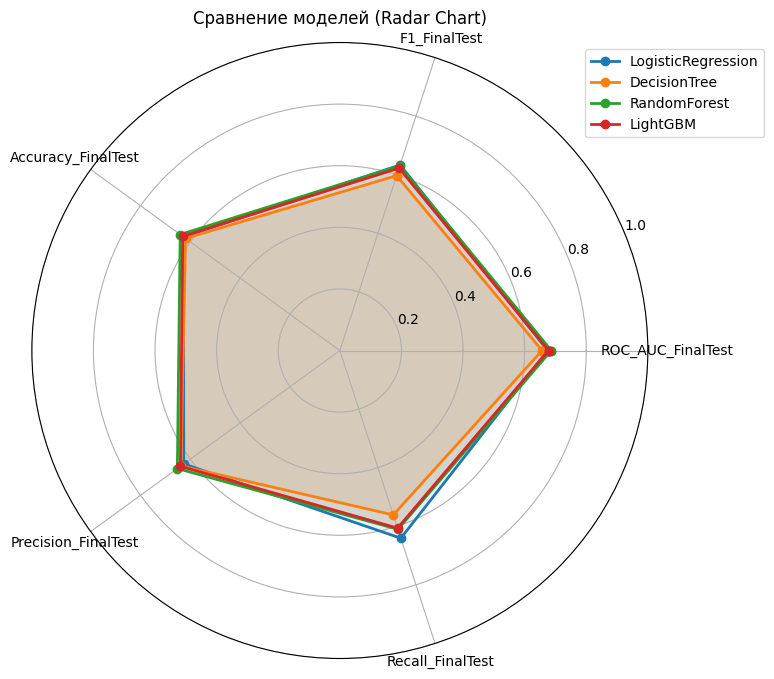

In [38]:
for res in study_results:
    name = res["Model"]
    model = best_models[name]

    y_val_pred = model.predict_proba(X_val)[:, 1]
    y_test_pred = model.predict_proba(X_final_test)[:, 1]

    y_val_bin = (y_val_pred >= 0.5).astype(int)
    y_test_bin = (y_test_pred >= 0.5).astype(int)

    res["ROC_AUC_Val"] = roc_auc_score(y_val, y_val_pred)
    res["ROC_AUC_FinalTest"] = roc_auc_score(y_final_test, y_test_pred)
    res["F1_Val"] = f1_score(y_val, y_val_bin)
    res["F1_FinalTest"] = f1_score(y_final_test, y_test_bin)
    res["Accuracy_Val"] = accuracy_score(y_val, y_val_bin)
    res["Accuracy_FinalTest"] = accuracy_score(y_final_test, y_test_bin)
    res["Precision_Val"] = precision_score(y_val, y_val_bin)
    res["Precision_FinalTest"] = precision_score(y_final_test, y_test_bin)
    res["Recall_Val"] = recall_score(y_val, y_val_bin)
    res["Recall_FinalTest"] = recall_score(y_final_test, y_test_bin)
    cm = confusion_matrix(y_final_test, y_test_bin)
    cm_df = pd.DataFrame(
        cm,
        index=["0", "1"],
        columns=["0", "1"]
    )

    logger.info(f"\n\n=== {name} ===")
    display(cm_df.style.set_caption("Confusion Matrix"))
    logger.info(f"ROC_AUC: {res['ROC_AUC_FinalTest']:.4f}")
    logger.info(f"Accuracy: {res['Accuracy_FinalTest']:.4f}")
    logger.info(f"F1 Score: {res['F1_FinalTest']:.4f}")
    logger.info(f"Precision: {res['Precision_FinalTest']:.4f}")
    logger.info(f"Recall: {res['Recall_FinalTest']:.4f}")
    logger.info("-" * 50)

results_df = pd.DataFrame(study_results)
display(results_df.sort_values("F1_FinalTest", ascending=False))

metrics_radar = ['ROC_AUC_FinalTest', 'F1_FinalTest', 'Accuracy_FinalTest', 'Precision_FinalTest', 'Recall_FinalTest']
categories = metrics_radar * 2

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, polar=True)

for i, res in enumerate(study_results):
    values = [res[metric] for metric in metrics_radar]
    values = values + values[:1]
    
    angles = [n / float(len(metrics_radar)) * 2 * np.pi for n in range(len(metrics_radar))]
    angles = angles + angles[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=res['Model'])
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics_radar)
ax.set_ylim(0, 1)
plt.title('Сравнение моделей (Radar Chart)')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

## Выводы

В таком виде конечно же результаты модели оставляют желать лучшего.  
Тем не менее в данном прогоне лучше всего себя показала LogisticRegression.  
Что касается матрицы ошибок - такая модель не годится для реальной работы и по всей видимости классические модели тоже.  
Также не стоит забывать что F1 метрика колеблится в районе 0.6, что не дотягивает до прод решения и нужны улучшения.

# Значимость признаков в моделе

In [39]:
def get_feature_names(preprocessor):
    """Улучшенная функция получения имен признаков с правильными OHE названиями."""
    feature_names = []
    
    for name, transformer, cols in preprocessor.transformers_:
        if transformer == "drop":
            continue
            
        logger.debug(f"Обработка transformer: {name}, колонки: {cols}")
            
        if name == "cyclic":
            cyclic_features = []
            if 'hour' in cols:
                cyclic_features.extend(['hour_sin', 'hour_cos'])
            if 'day_of_week' in cols:
                cyclic_features.extend(['day_of_week_sin', 'day_of_week_cos'])
            if 'day_of_month' in cols:
                cyclic_features.extend(['day_of_month_sin', 'day_of_month_cos'])
            feature_names.extend(cyclic_features)
            logger.debug(f"Добавлены циклические признаки: {cyclic_features}")
            continue
                
        if isinstance(transformer, Pipeline):
            if name == "cat":
                ohe_step = None
                for step_name, step_transformer in transformer.steps:
                    if hasattr(step_transformer, 'get_feature_names_out'):
                        ohe_step = step_transformer
                        break
                
                if ohe_step and hasattr(ohe_step, 'get_feature_names_out'):
                    try:
                        ohe_features = ohe_step.get_feature_names_out(cols)
                        feature_names.extend(ohe_features)
                        logger.info(f"Успешно получены OHE имена: {list(ohe_features)}")
                    except Exception as e:
                        logger.warning(f"Ошибка в get_feature_names_out: {e}")
                        self._add_manual_ohe_names(feature_names, cols)
                else:
                    self._add_manual_ohe_names(feature_names, cols)
                    
            elif name == "num":
                feature_names.extend(cols)
                
        elif transformer == "passthrough":
            feature_names.extend(cols)
            
        elif hasattr(transformer, "get_feature_names_out"):
            try:
                features = transformer.get_feature_names_out(cols)
                feature_names.extend(features)
            except Exception as e:
                logger.warning(f"Ошибка get_feature_names_out для {name}: {e}")
                feature_names.extend(cols)
                
        else:
            feature_names.extend(cols)
    
    return feature_names

def _add_manual_ohe_names(feature_names, cols):
    """Добавляет OHE имена вручную на основе данных."""
    for col in cols:
        try:
            unique_vals = X_train[col].dropna().unique()
            unique_vals = sorted(unique_vals)
            
            if len(unique_vals) > 1:
                for val in unique_vals[1:]:
                    safe_val = str(val).replace(' ', '_').replace('/', '_')
                    feature_names.append(f"{col}_{safe_val}")
            else:
                feature_names.append(f"{col}_encoded")
                
        except Exception as e:
            logger.warning(f"Ошибка создания OHE имен для {col}: {e}")
            feature_names.append(f"{col}_encoded")

In [40]:
best_row = results_df.sort_values("F1_FinalTest", ascending=False).iloc[0]
best_model_name = best_row["Model"]
best_model = best_models[best_model_name]

logger.info(f"=== Анализ признаков и SHAP для лучшей модели: {best_model_name} ===")

preprocessor = best_model.named_steps["preprocessor"]
selector = best_model.named_steps["selectkbest"]
classifier = best_model.named_steps["classifier"]

try:
    all_features = preprocessor.get_feature_names_out()
    logger.info("Использован preprocessor.get_feature_names_out()")
except Exception as e:
    logger.warning(f"preprocessor.get_feature_names_out() failed: {e}")
    all_features = get_feature_names(preprocessor)
    logger.info("Использована кастомная функция get_feature_names()")

all_features = np.array(all_features)

logger.info(f"Всего признаков до SelectKBest: {len(all_features)}")
logger.info(f"Тип all_features: {type(all_features)}")
logger.info(f"Примеры признаков: {all_features[:5]}")

mask = selector.get_support()
logger.info(f"Тип mask: {type(mask)}, форма: {mask.shape}")

selected_features = all_features[mask]

logger.info(f"Выбрано признаков SelectKBest: {len(selected_features)}")
logger.info(f"Top features: {selected_features}")

2025-11-28 10:07:17 [INFO] __main__: === Анализ признаков и SHAP для лучшей модели: LogisticRegression ===
2025-11-28 10:07:17 [WARNING] __main__: preprocessor.get_feature_names_out() failed: Estimator to_str does not provide get_feature_names_out. Did you mean to call pipeline[:-1].get_feature_names_out()?
2025-11-28 10:07:17 [INFO] __main__: Успешно получены OHE имена: ['weather_1_cloudy', 'weather_1_fog', 'weather_1_other', 'weather_1_raining', 'weather_1_snowing', 'weather_1_unknown', 'weather_1_wind', 'road_surface_slippery', 'road_surface_snowy', 'road_surface_unknown', 'road_surface_wet', 'lighting_dark with street lights', 'lighting_dark with street lights not functioning', 'lighting_daylight', 'lighting_dusk or dawn', 'lighting_unknown', 'location_type_intersection', 'location_type_ramp', 'location_type_unknown', 'road_condition_1_flooded', 'road_condition_1_holes', 'road_condition_1_loose material', 'road_condition_1_normal', 'road_condition_1_obstruction', 'road_condition_1_

2025-11-28 10:07:17 [INFO] __main__: Вычисление SHAP для LogisticRegression...
2025-11-28 10:07:17 [INFO] __main__: Топ-20 признаков по SHAP: ['vehicle_type_sedan', 'insurance_premium', 'hour_cos', 'vehicle_transmission_manual', 'hour_sin', 'control_device_none', 'intersection', 'vehicle_age', 'county_city_location_1942', 'road_surface_wet', 'lighting_dark with street lights', 'weather_1_cloudy', 'direction_unknown', 'lighting_daylight', 'weather_1_raining', 'road_surface_snowy']


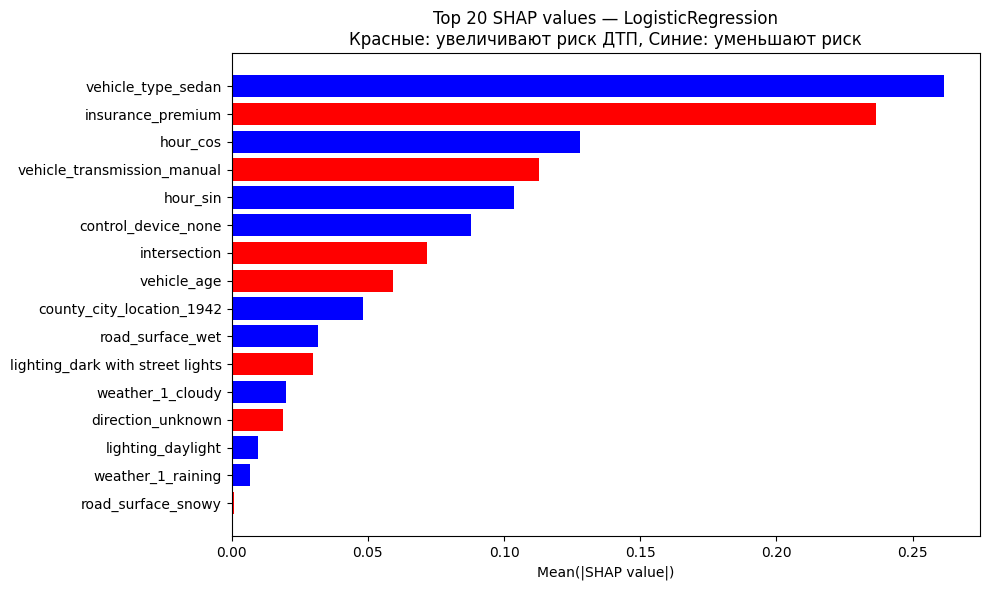

2025-11-28 10:07:17 [INFO] __main__: Построение SHAP Beeswarm Plot...


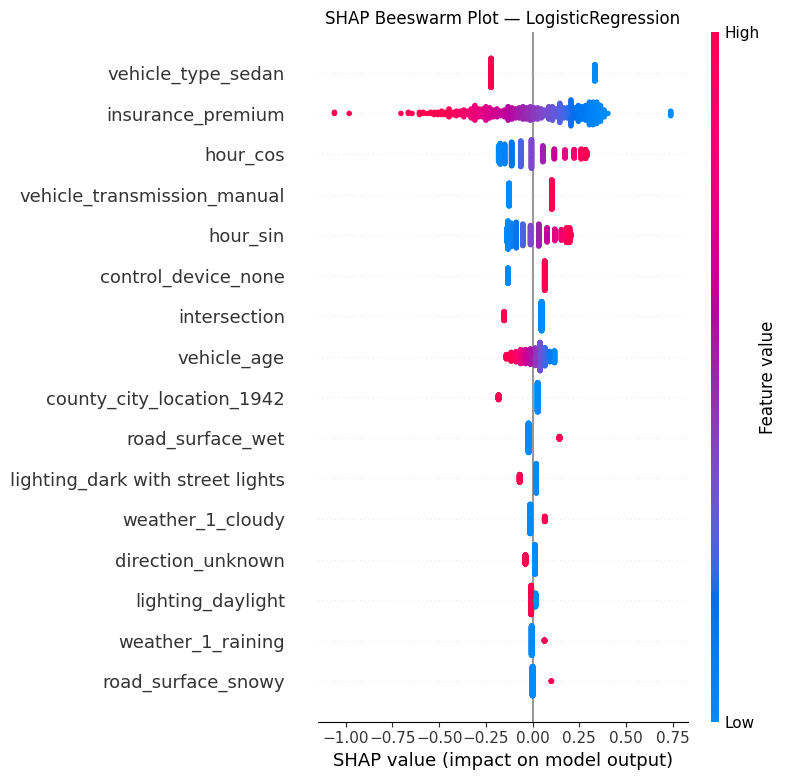

2025-11-28 10:07:17 [INFO] __main__: SHAP-анализ завершён для LogisticRegression


In [41]:
N = 20

classifier = list(best_model.named_steps.values())[-1]

feature_importance = None
if hasattr(classifier, "feature_importances_"):
    feature_importance = pd.DataFrame({
        "feature": selected_features,
        "importance": classifier.feature_importances_
    }).sort_values("importance", ascending=False)
elif hasattr(classifier, "coef_"):
    coefs = classifier.coef_[0]
    feature_importance = pd.DataFrame({
        "feature": selected_features,
        "importance": coefs
    }).sort_values("importance", key=np.abs, ascending=False)

logger.info(f"Вычисление SHAP для {best_model_name}...")

# Получаем преобразованные данные
X_train_transformed = preprocessor.transform(X_train)
X_train_selected = selector.transform(X_train_transformed)
X_selected_df = pd.DataFrame(X_train_selected, columns=selected_features)

sample_size = min(500, len(X_selected_df))
if len(X_selected_df) > sample_size:
    sample_idx = np.random.choice(len(X_selected_df), sample_size, replace=False)
    X_sample = X_selected_df.iloc[sample_idx]
else:
    X_sample = X_selected_df

# Выбираем explainer
if best_model_name == "LogisticRegression":
    explainer = shap.LinearExplainer(classifier, X_sample)
    shap_values = explainer.shap_values(X_sample)
else:
    explainer = shap.TreeExplainer(classifier)
    shap_values = explainer.shap_values(X_sample)
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # бинарная классификация: берем класс 1

# Убедимся, что shap_values — это 2D numpy массив (n_samples, n_features)
if hasattr(shap_values, "values"):
    # Случай, когда возвращается shap.Explanation объект
    shap_values = shap_values.values

# Приводим к numpy и убеждаемся, что 2D
shap_values = np.asarray(shap_values)
if shap_values.ndim == 1:
    shap_values = shap_values.reshape(-1, 1)

# Теперь вычисляем средние значения
mean_shap_by_feature = np.mean(shap_values, axis=0)
shap_importance = np.mean(np.abs(shap_values), axis=0)

# Убедимся, что векторы 1D
mean_shap_by_feature = np.squeeze(mean_shap_by_feature)
shap_importance = np.squeeze(shap_importance)

shap_df = pd.DataFrame({
    "feature": selected_features,
    "mean_shap": mean_shap_by_feature,
    "mean_abs_shap": shap_importance
}).sort_values("mean_abs_shap", ascending=False)

top_shap_features = shap_df.head(N)
top_shap_features_list = top_shap_features["feature"].tolist()
logger.info(f"Топ-{N} признаков по SHAP: {top_shap_features_list}")

# Визуализация
plt.figure(figsize=(10, 6))
bar_colors = ['red' if val > 0 else 'blue' for val in top_shap_features["mean_shap"]]
plt.barh(top_shap_features["feature"][::-1], 
         top_shap_features["mean_abs_shap"][::-1], 
         color=bar_colors[::-1])
plt.title(f"Top {N} SHAP values — {best_model_name}\nКрасные: увеличивают риск ДТП, Синие: уменьшают риск")
plt.xlabel("Mean(|SHAP value|)")
plt.tight_layout()
plt.show()

logger.info("Построение SHAP Beeswarm Plot...")
shap.summary_plot(
    shap_values,
    features=X_sample,
    feature_names=selected_features,
    plot_type="dot",
    show=False
)
plt.title(f"SHAP Beeswarm Plot — {best_model_name}")
plt.tight_layout()
plt.show()

logger.info(f"SHAP-анализ завершён для {best_model_name}")

2025-11-28 10:07:17 [INFO] __main__: Permutation Importance (важность признаков)


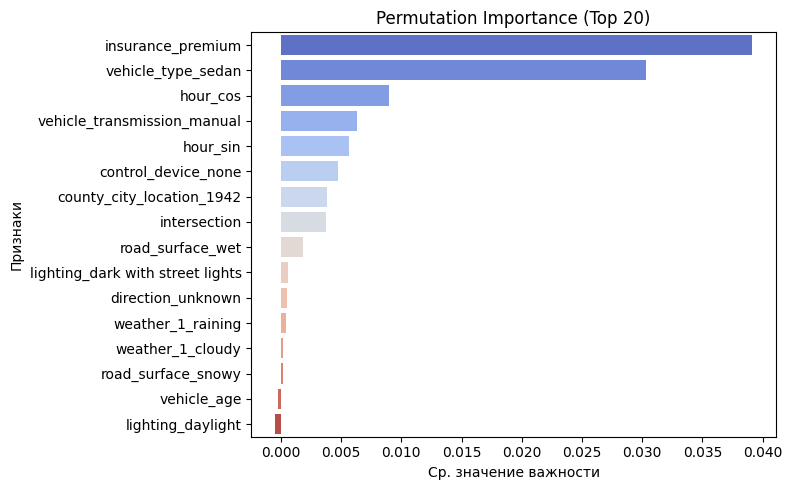

2025-11-28 10:07:25 [INFO] __main__: Анализ признаков завершён для LogisticRegression


In [42]:
logger.info("Permutation Importance (важность признаков)")

try:
    perm_importance = permutation_importance(
        classifier,
        X_selected_df,
        y_train,
        n_repeats=5,
        random_state=42,
        n_jobs=-1
    )

    perm_df = pd.DataFrame({
        "feature": selected_features,
        "importance": perm_importance.importances_mean
    }).sort_values("importance", ascending=False)

    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=perm_df.head(N),
        x="importance",
        y="feature",
        hue="feature",
        palette="coolwarm",
        dodge=False,
        legend=False
    )
    plt.title(f"Permutation Importance (Top {N})")
    plt.xlabel("Ср. значение важности")
    plt.ylabel("Признаки")
    plt.tight_layout()
    plt.show()

except Exception as e:
    logger.error(f"Ошибка при вычислении Permutation Importance: {e}")

logger.info(f"Анализ признаков завершён для {best_model_name}")

# Ключевые вопросы для исследования и выводы

1. **Возможность создания системы**
   - Можно ли адекватно оценивать водительский риск при выдаче авто?

Ответ: да, можно.  
но! тут стоит учитываться ряд сведений:  
1) Есть ли история по этому человеку;  
2) Есть ли уже проложенный маршрут слеования;  
3) Какие датчики есть в авто:  
- камерв - фиксируют его внешнее состояние, девиантное;  
- микрофоны - его речь, нормальная ли она, если он ведет диалог или не дай бог монолог :) + не ребенок ли;  
- воздушные датчики - алкоголь и тп;   

2. **Дополнительные факторы**
   - Какие данные необходимо собирать для улучшения модели?  

Ответ:  
1) История вождения;  
2) Данные с датчиков;  

3. **Техническое оснащение**
   - Нужно ли оборудовать автомобиль датчиками или камерами?  

Ответ:  

Да, это позволить более качественно оценивать риск возникновения ДТП с конкретным водителем.

## На основе модели исследовать основные факторы ДТП

Итак, что мы имеем.  
Наиболее сильными факторами влияющими на риск дтп являются:  
1) Отсутствие регулирующих устройств (светофоры, шлагбаумы и т.п. и т.д.);  
2) Мокрая дорога;  
3) Ручная коробка передач;  
4) Снежная дорога;  
5) Дневное время;  
6) И другие.  

# Задачи для изучения

## 1) Оценить влияние погоды (weather_1) на вероятность ДТП по вине водителя

In [43]:
query = '''SELECT 
    c.weather_1,
    p.at_fault,
    COUNT(*) AS cnt
FROM collisions c
JOIN parties p ON c.case_id = p.case_id
JOIN vehicles v ON c.case_id = v.case_id AND p.party_number = v.party_number
WHERE c.collision_date < '2012-12-31'
  AND c.collision_date > '2008-12-31'
  AND c.collision_damage <> 'scratch'
  AND p.party_type = 'car'
  AND v.vehicle_age < 11
GROUP BY c.weather_1, p.at_fault
ORDER BY cnt DESC;'''

2025-11-28 10:07:25 [INFO] __main__: Загружаем данные по SQL-запросу...
2025-11-28 10:07:28 [INFO] __main__: Загружено: 16 строк, 3 столбцов


<Axes: xlabel='weather_1'>

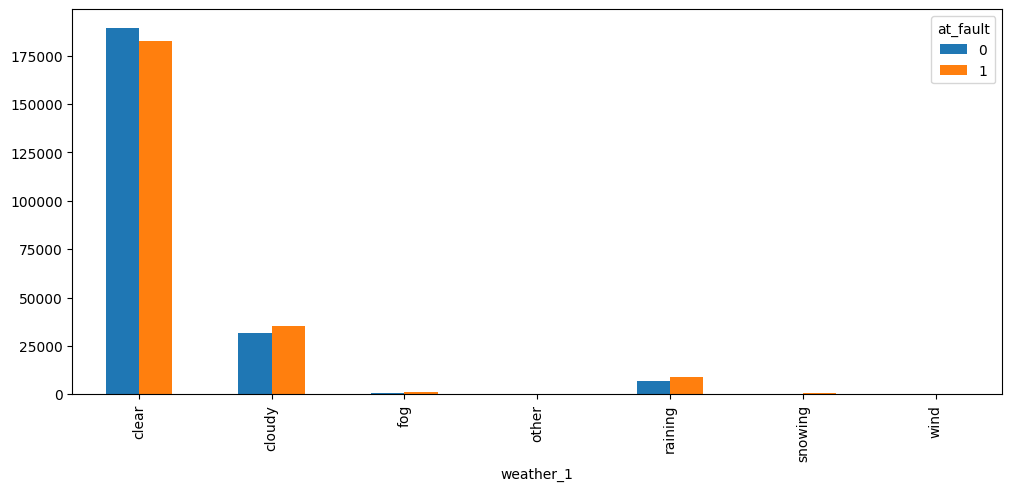

In [44]:
filtered_tables_config = {'df_weather': query}
df_weather_dict = load_all_tables_safe(engine, filtered_tables_config)
df_weather = df_weather_dict['df_weather']
(
    df_weather
    .pivot_table(
        index='weather_1',
        columns='at_fault',
        values='cnt',
        aggfunc='sum'
    )
    .plot(kind='bar', figsize=(12, 5))
)

### Выводы

Как видим из графика - погода практически не влияет на факт ДТП, что кстати, достаточно подозрительно...

## 2) Проанализировать зависимость риска ДТП от возраста автомобиля (vehicle_age)

In [45]:
query = '''SELECT 
    v.vehicle_age,
    p.at_fault,
    COUNT(*) AS cnt
FROM collisions c
JOIN parties p ON c.case_id = p.case_id
JOIN vehicles v ON c.case_id = v.case_id AND p.party_number = v.party_number
WHERE c.collision_date < '2012-12-31'
  AND c.collision_date > '2008-12-31'
  AND c.collision_damage <> 'scratch'
  AND p.party_type = 'car'
  AND v.vehicle_age < 11
GROUP BY v.vehicle_age, p.at_fault
ORDER BY v.vehicle_age;'''

2025-11-28 10:07:28 [INFO] __main__: Загружаем данные по SQL-запросу...
2025-11-28 10:07:32 [INFO] __main__: Загружено: 22 строк, 3 столбцов


<Axes: xlabel='vehicle_age'>

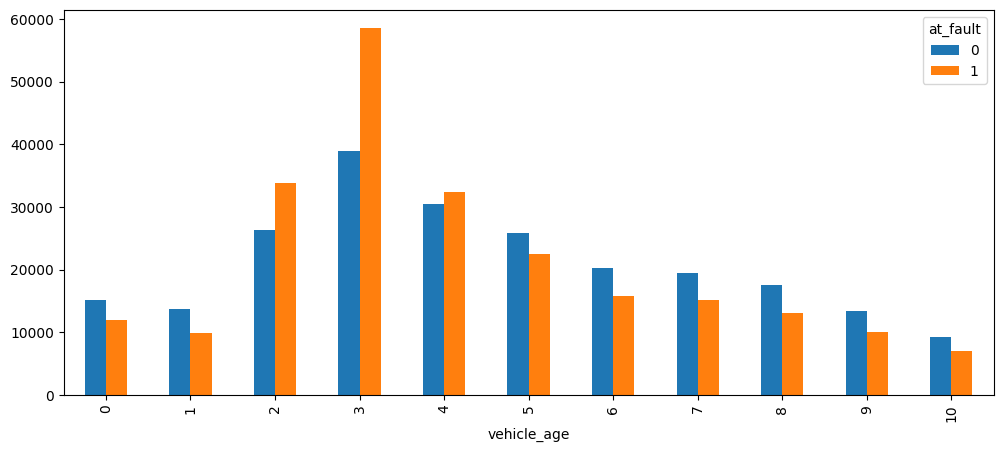

In [46]:
filtered_tables_config = {'df_age': query}
df_age_dict = load_all_tables_safe(engine, filtered_tables_config)
df_age = df_age_dict['df_age']
(
    df_age
    .pivot_table(
        index='vehicle_age',
        columns='at_fault',
        values='cnt',
        aggfunc='sum'
    )
    .plot(kind='bar', figsize=(12, 5))
)

### Выводы

В целом возраст автомобиля также не влияет на риск ДТП, есть конечно же всплеск у 3х леток, возможно влияет выход из строя основных узлов, учитывая большой и быстро растущий пробег.

## Еще 4 задачи

1. Проанализировать, как состояние покрытия дороги влияет на вероятность ДТП  
Использовать: road_surface, at_fault.  

2. Оценить связь типа трансмиссии с вероятностью быть виновником  
Использовать: vehicle_transmission, at_fault.  

3. Найти влияние освещённости (lighting) на риск ДТП по вине водителя  
Использовать: lighting, at_fault.  

4. Проанализировать влияние использования телефона на вероятность виновности  
Использовать: cellphone_in_use, at_fault.  